In [1]:
%cd ../..

/home/eli/AnacondaProjects/epych


In [2]:
%env DASK_LOGGING__DISTRIBUTED=CRITICAL
%env SPYTMPDIR=/mnt/data/tmp_storage
%env SPYLOGLEVEL=CRITICAL
%env SPYPARLOGLEVEL=CRITICAL

env: DASK_LOGGING__DISTRIBUTED=CRITICAL
env: SPYTMPDIR=/mnt/data/tmp_storage
env: SPYLOGLEVEL=CRITICAL
env: SPYPARLOGLEVEL=CRITICAL


In [3]:
import collections
import functools
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import quantities as pq

import epych
from epych.statistics import alignment, spectrum

[striatum:61100] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.striatum.1000/jf.0/1949958144/shared_mem_cuda_pool.striatum could be created.
[striatum:61100] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [4]:
%matplotlib inline

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
SECOND_ONSET = pq.Quantity(-2.0) * pq.second
SECOND_OFFSET = pq.Quantity(-1.5) * pq.second
ADAPTED_ONSET = pq.Quantity(-1.0) * pq.second
ADAPTED_OFFSET = pq.Quantity(-0.5) * pq.second
ODDBALL_ONSET = pq.Quantity(-1.9017372477960602e-14) * pq.second
ODDBALL_OFFSET = pq.Quantity(0.5004545430388676) * pq.second
OFFSET = pq.Quantity(0.25) * pq.second
EVENTS = {
    "Oddball": (ODDBALL_ONSET.magnitude, 'lightgreen'),
    "Offset": (ODDBALL_OFFSET.magnitude, 'red'),
}
ADAPTED_EVENTS = {
    "Offset": (ADAPTED_OFFSET.magnitude, 'red'),
    "Oddball": (ODDBALL_ONSET.magnitude, 'lightgreen'),
}
FREQ_RANGE = (spectrum.THETA_BAND[0].magnitude, spectrum.GAMMA_BAND[1].magnitude)

In [7]:
CONDITIONS = ["lonaive", "go_gloexp", "go_seqctl", "lo_gloexp", "lo_rndctl", "igo_seqctl"]

In [8]:
area_titles = {
    "VISal": "AL",
    "VISam": "AM",
    "VISl": "LM",
    "VISp": "V1",
    "VISpm": "PM",
    "VISrl": "RL",
}
def stattitle(name, stat):
    if name in area_titles:
        return area_titles[name]
    return name
anatomical_areas = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']

In [9]:
def initialize_spectrum(key, signal, path=None):
    area = os.path.commonprefix([loc for loc in signal.channels.location])
    return epych.statistics.spectrum.Spectrogram(signal.df, signal.channels, signal.f0, chunk_trials=3, taper="hann", path=path + "/" + key)

In [10]:
spectrograms = {}

In [11]:
for cond in CONDITIONS:
    cond_path = "/mnt/data/000253/grand_spectrogram_downsample8_%s" % cond
    spectrograms[cond] = epych.statistic.Summary.unpickle(cond_path, epych.statistics.spectrum.Spectrogram)
    logging.info("Loaded LFP spectrograms across condition %s" % cond)

INFO:root:Loaded LFP spectrograms across condition lonaive
INFO:root:Loaded LFP spectrograms across condition go_gloexp
INFO:root:Loaded LFP spectrograms across condition go_seqctl
INFO:root:Loaded LFP spectrograms across condition lo_gloexp
INFO:root:Loaded LFP spectrograms across condition lo_rndctl
INFO:root:Loaded LFP spectrograms across condition igo_seqctl


In [12]:
PVALUE = 5e-2

In [13]:
CONTRASTS = [("go_contrast", "go_gloexp", "go_seqctl"), ("ssa", "lo_gloexp", "igo_seqctl"), ("dd", "lo_rndctl", "lonaive")]

In [14]:
CONTRAST_TITLES = {
    "go_contrast": "Global Oddball vs AAAA Control",
    "ssa": "Local Oddball vs BBBB Control",
    "dd": "AAAB Random Control vs AAAB Naive"
}
def contrast_stattitle(contrast, name, stat):
    return stattitle(name, stat) + (" (%s)" % CONTRAST_TITLES[contrast])

In [15]:
def initialize_grand_cluster_test(key, signals):
    return epych.statistics.grand.GrandNonparametricClusterTest(signals[0].num_channels, len(signals[0].times), alpha=PVALUE, partitions=1000)

In [16]:
def baselined_spectrogram(spectrogram):
    return spectrogram.oscillatory().baseline(-3.5 * pq.second, -3.0 * pq.second, decibels=True)

def oscillatory_4minus3(spectrogram):
    spectrogram = baselined_spectrogram(spectrogram)
    diff = spectrogram[(ODDBALL_ONSET - OFFSET).magnitude:(ODDBALL_OFFSET + OFFSET).magnitude] - spectrogram[(ADAPTED_ONSET - OFFSET).magnitude:(ADAPTED_OFFSET + OFFSET).magnitude]
    return diff.shift_timestamps(-OFFSET)

def prestimulus_4minus3(spectrogram):
    spectrogram = baselined_spectrogram(spectrogram)
    diff = spectrogram[(ADAPTED_OFFSET - OFFSET).magnitude:(ODDBALL_ONSET + OFFSET).magnitude] - spectrogram[(SECOND_OFFSET - OFFSET).magnitude:(ADAPTED_ONSET + OFFSET).magnitude]
    return diff.shift_timestamps(-OFFSET + ADAPTED_OFFSET)

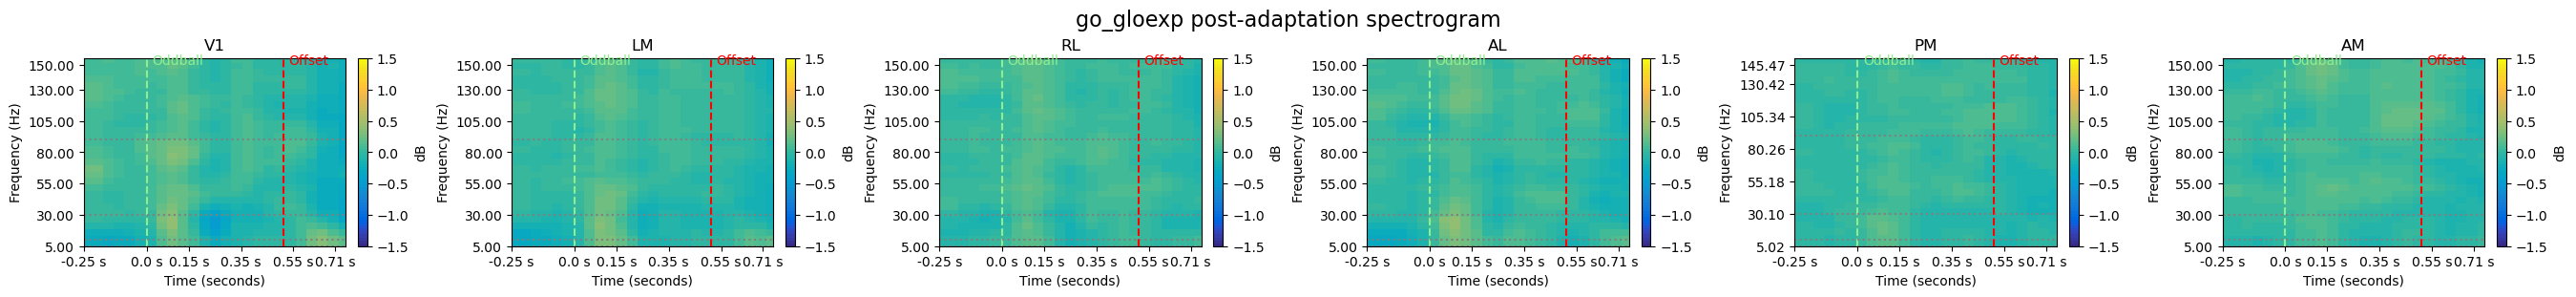

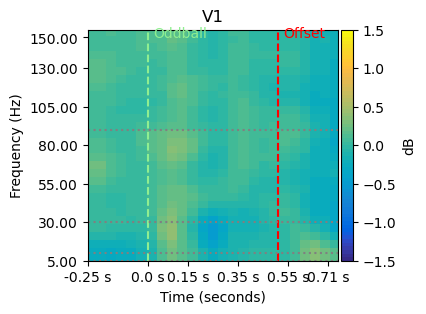

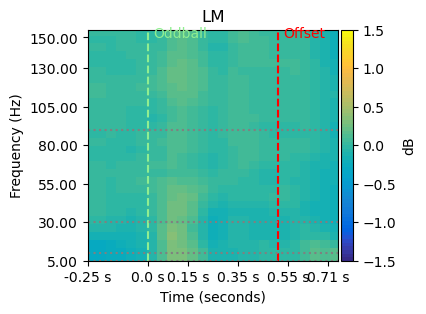

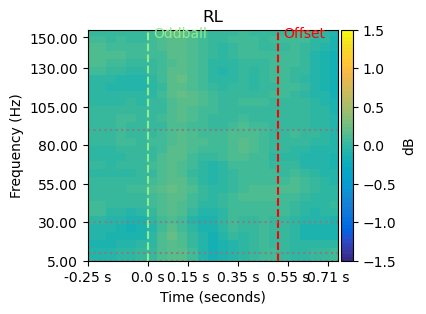

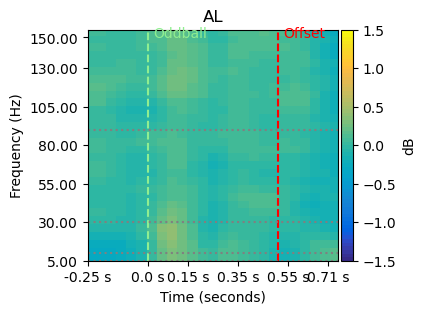

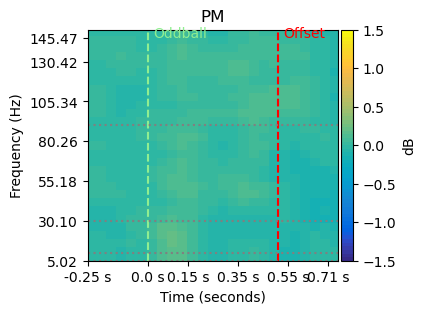

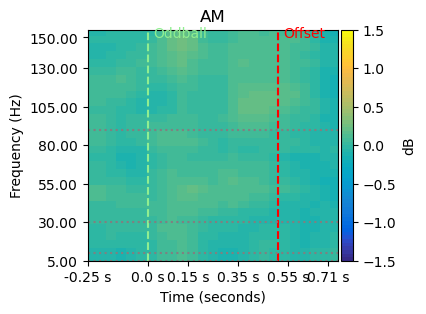

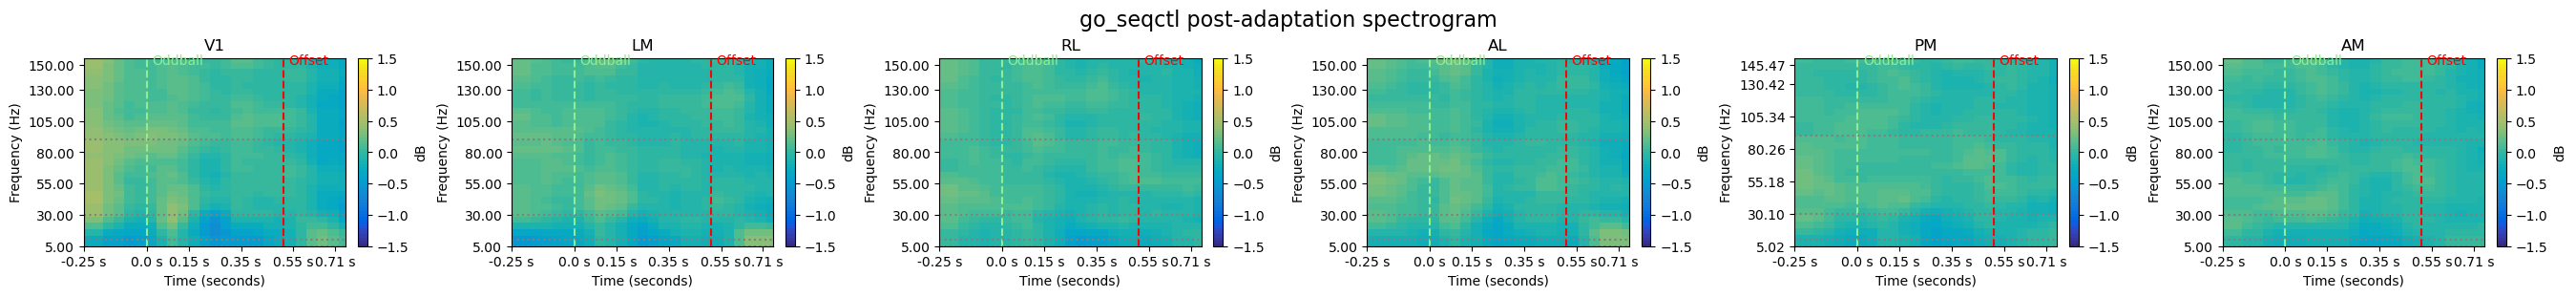

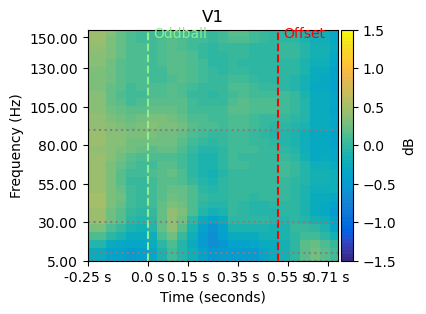

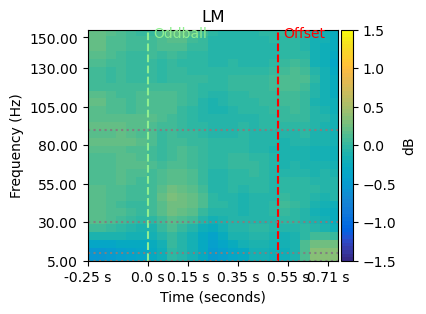

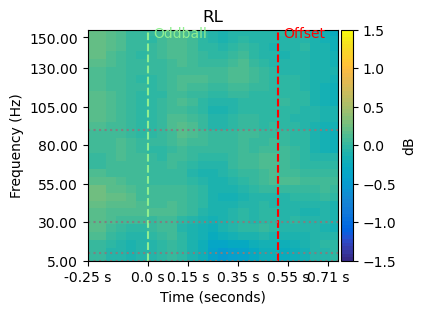

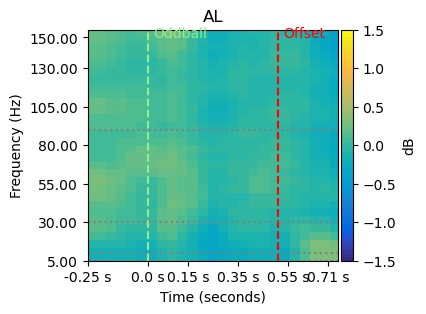

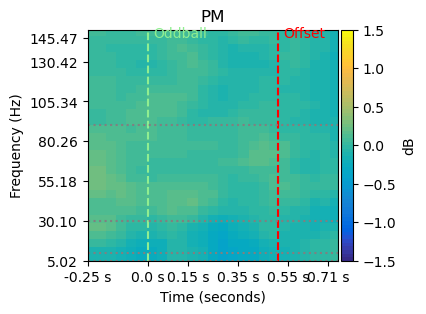

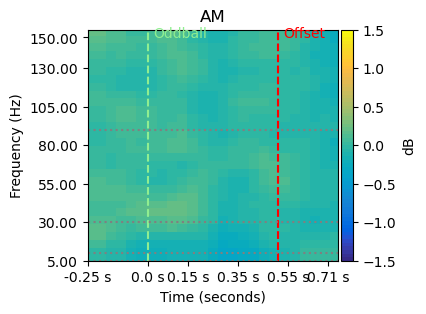

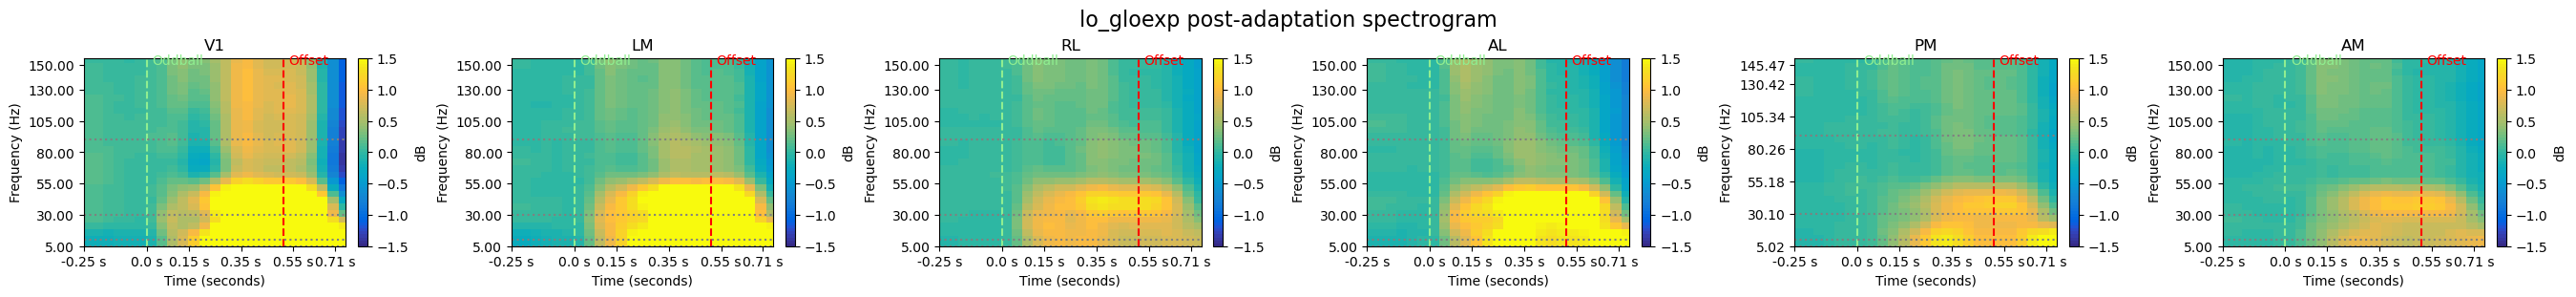

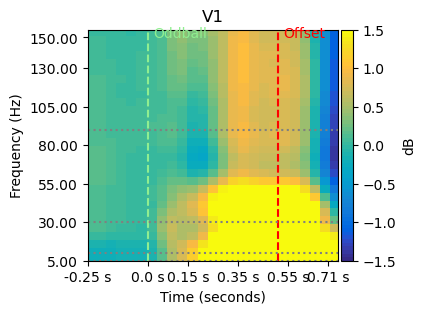

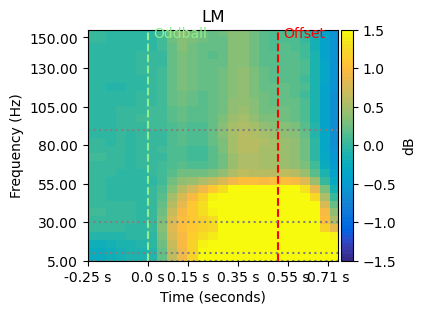

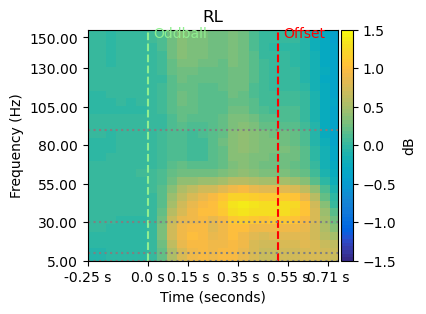

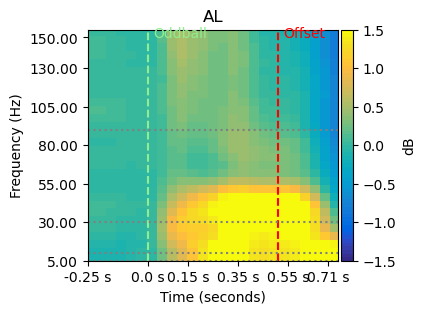

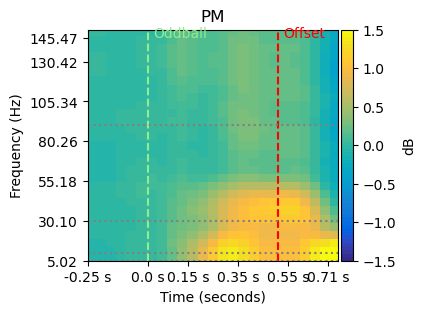

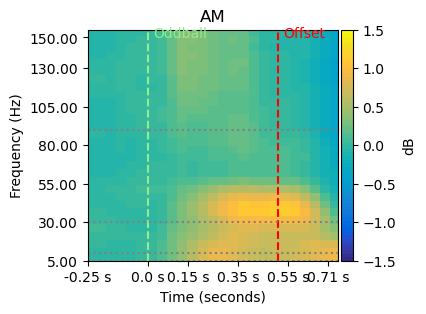

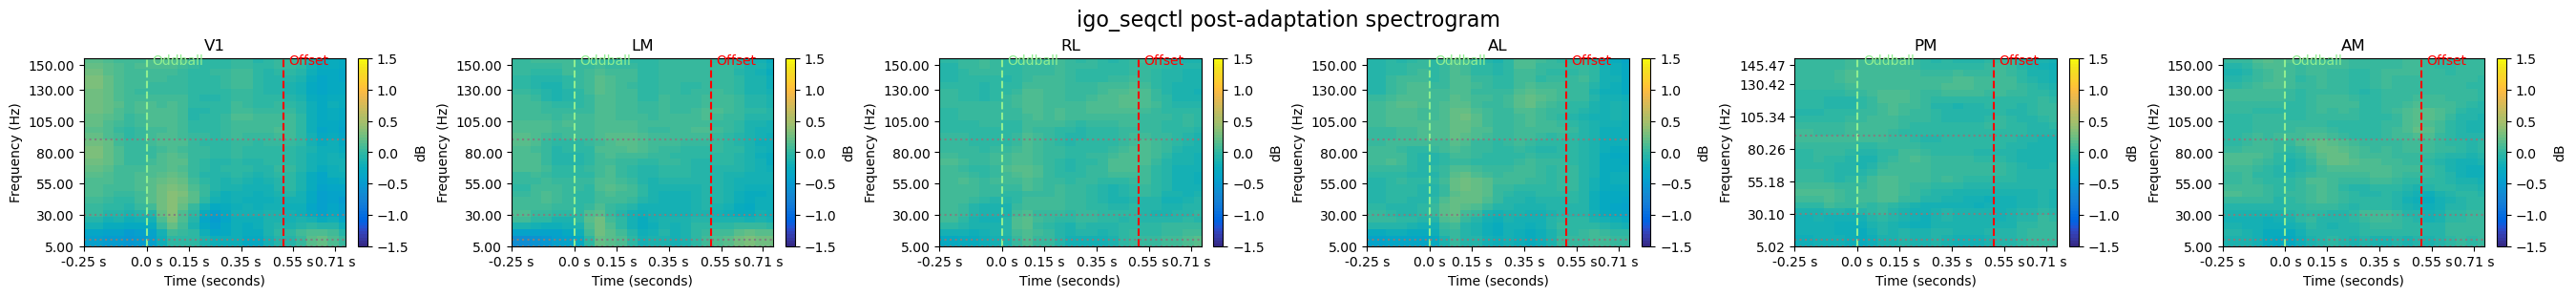

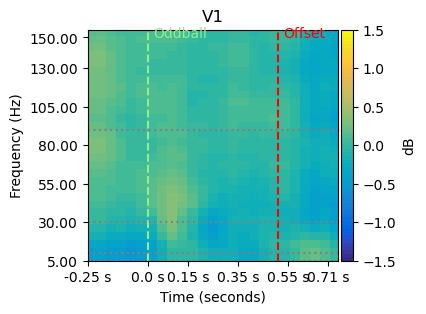

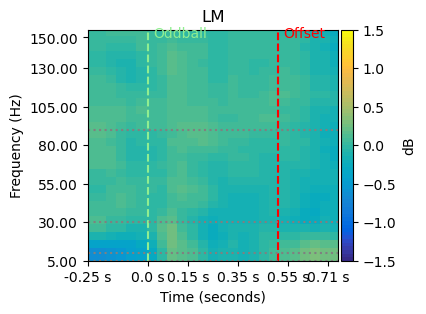

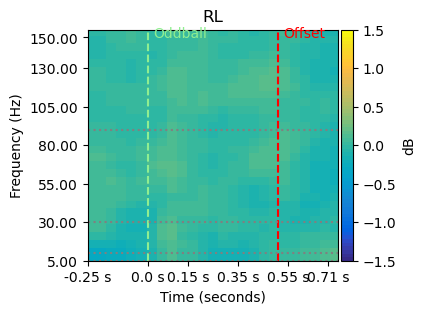

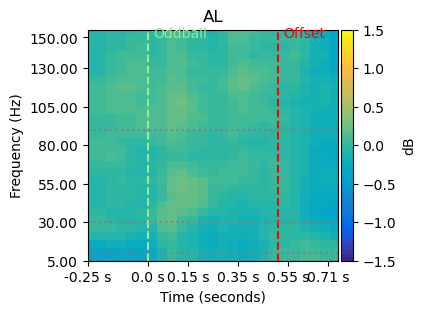

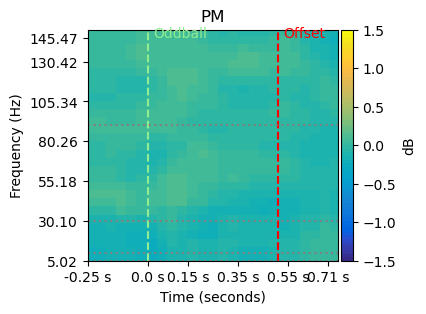

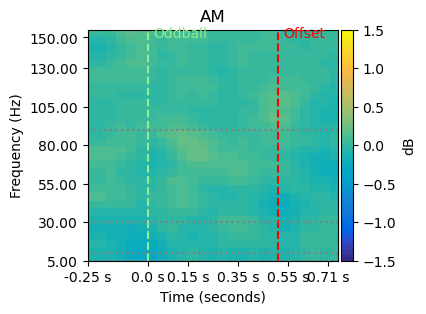

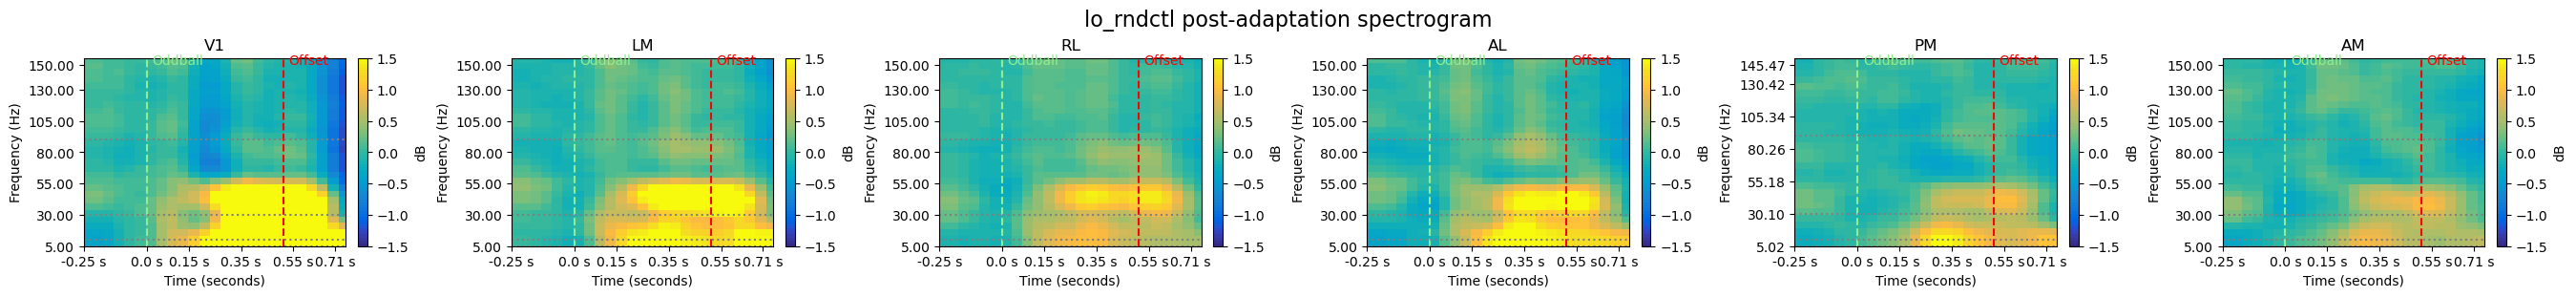

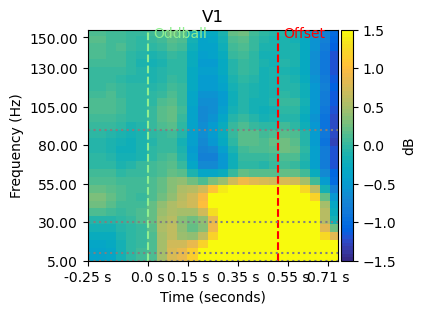

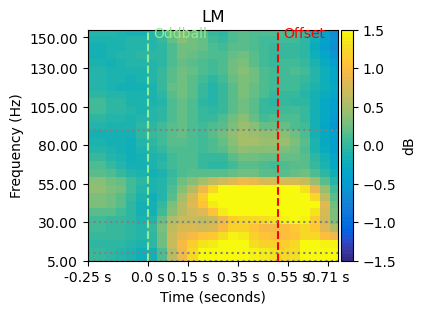

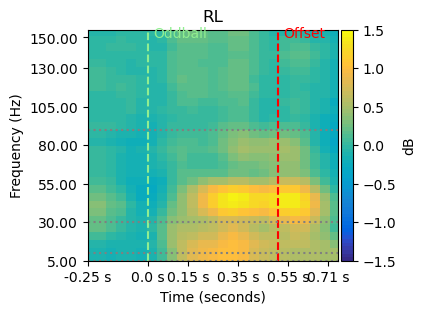

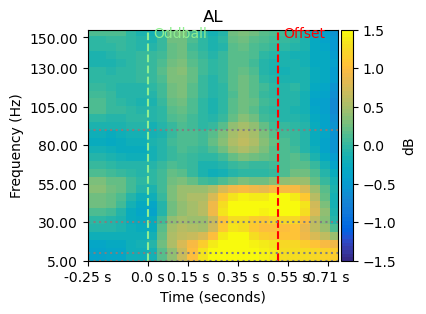

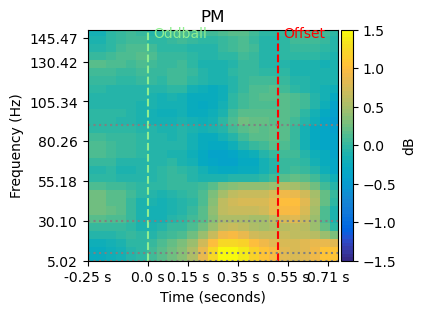

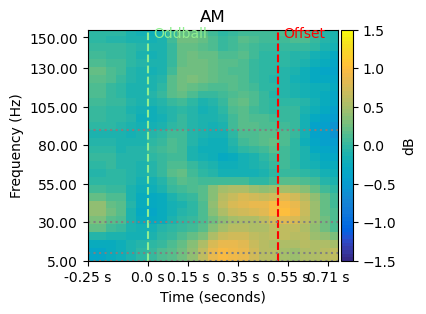

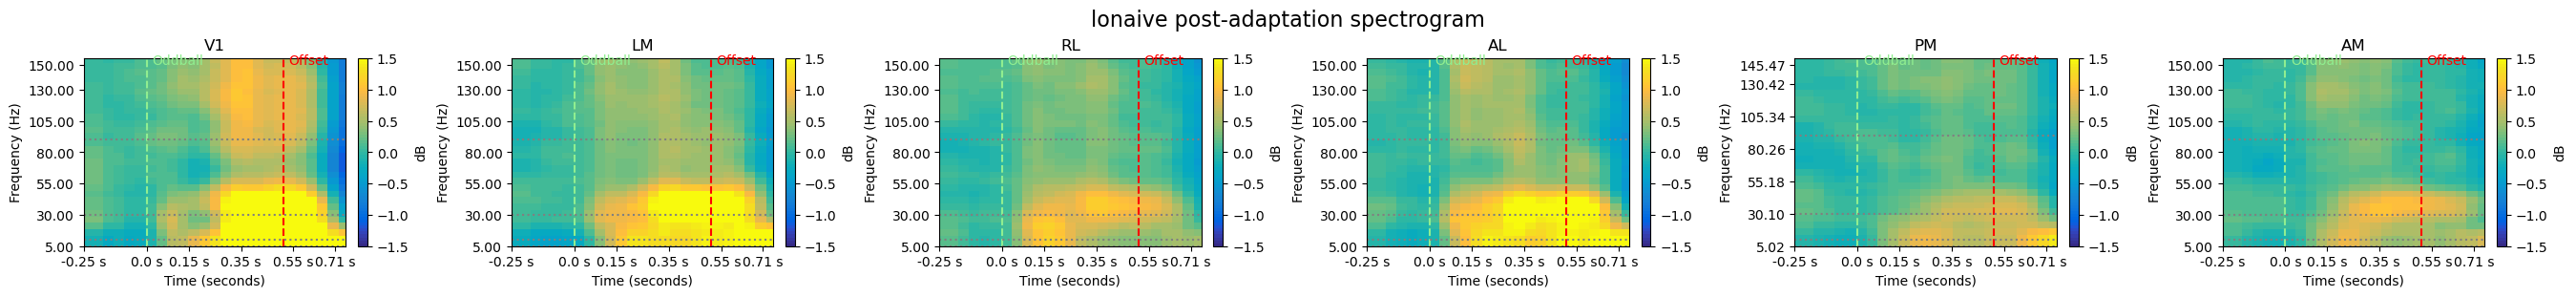

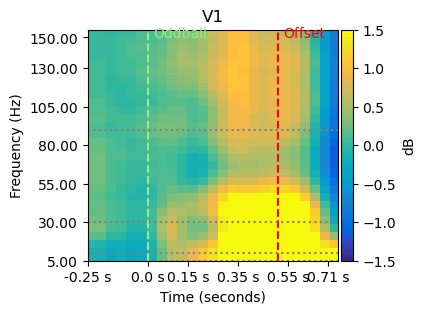

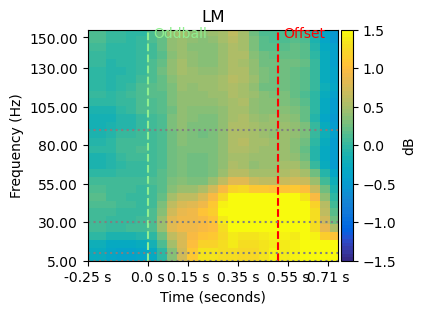

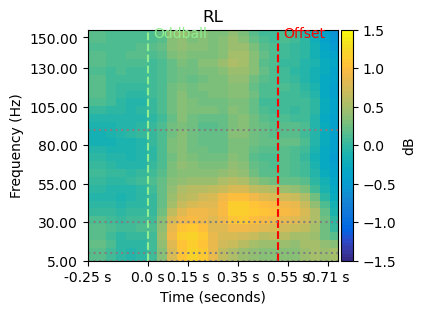

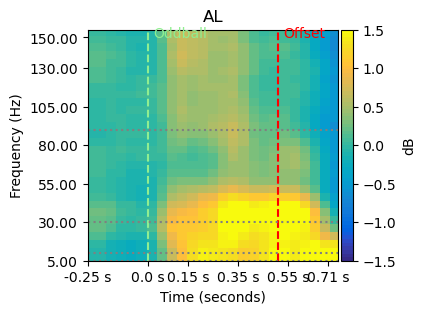

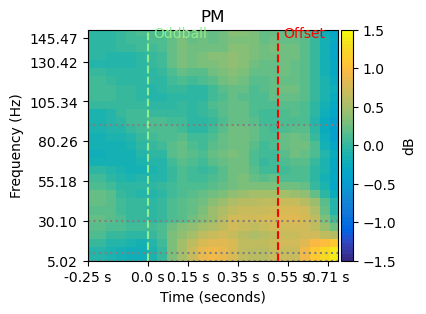

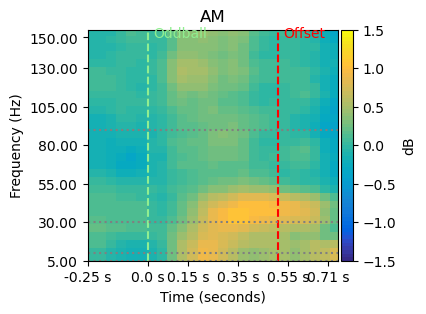

In [17]:
for cond in itertools.chain(*[[c1, c2] for (_, c1, c2) in CONTRASTS]):
    diffs = epych.recording.Sampling(epych.recording.empty_intervals(), spectrograms[cond]._trials, epych.recording.default_units(), **{
        k: oscillatory_4minus3(v.result()) for k, v in spectrograms[cond].stats.items()
    }).erp()
    diffs.plot(signals=anatomical_areas, sigtitle=stattitle, vmax=1.5, vmin=-1.5, title=cond + " post-adaptation spectrogram",
               figure="oscillatory_4-3_%s.pdf" % cond, **EVENTS)
    for area in anatomical_areas:
        os.makedirs("oscillatory_4-3_%s/" % cond, exist_ok=True)
        diffs.signals[area].plot(title=area_titles[area], vmax=1.5, vmin=-1.5, filename="oscillatory_4-3_%s/%s.pdf" % (cond, area),
                                 **EVENTS)

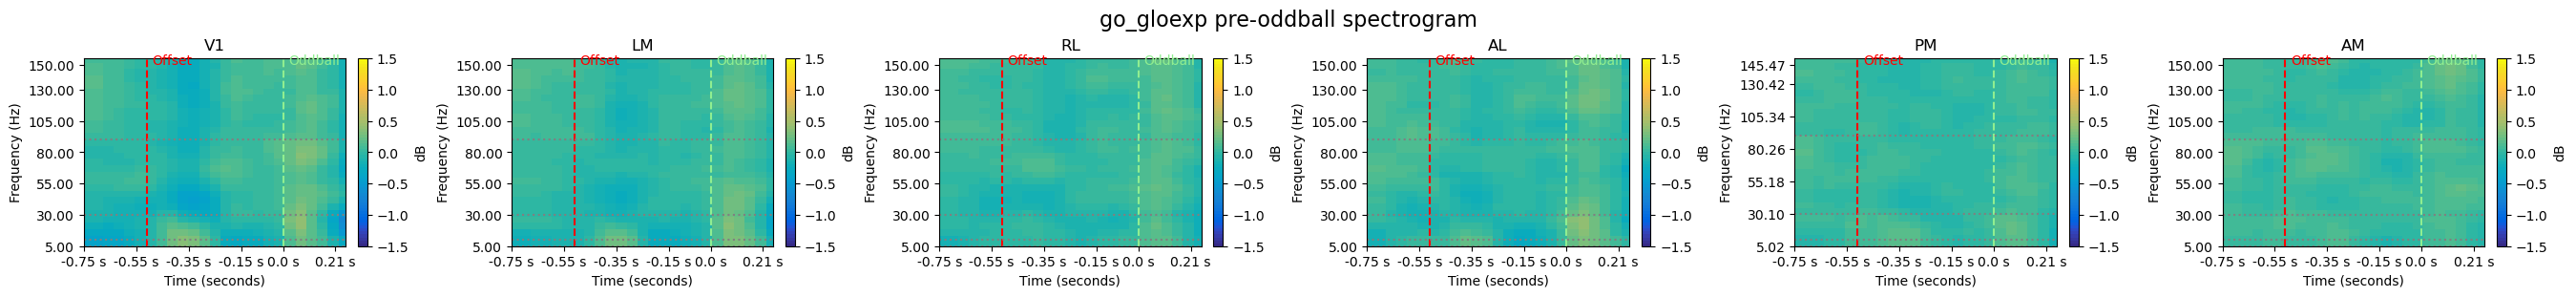

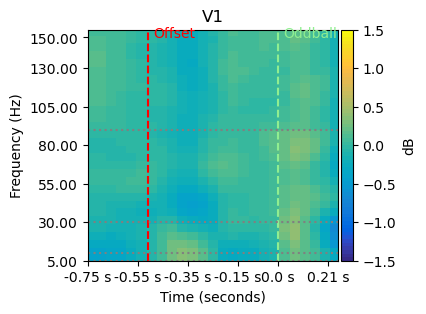

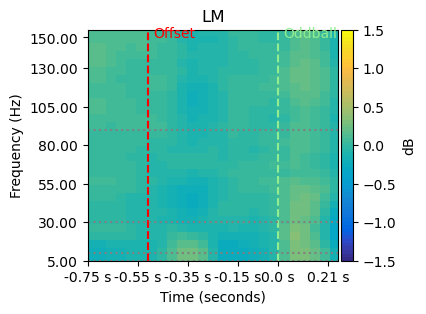

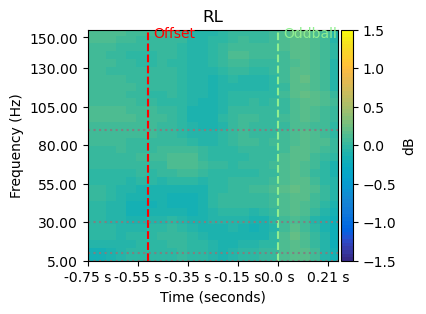

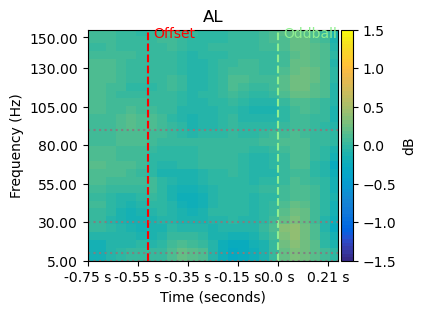

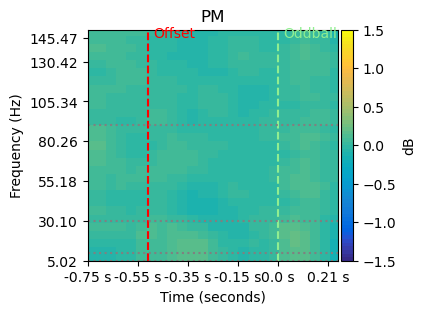

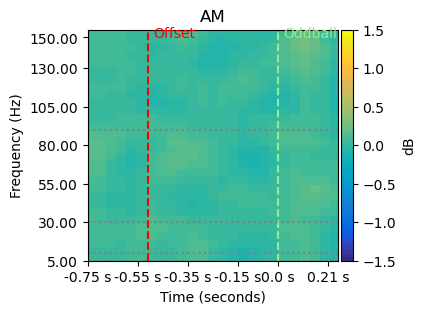

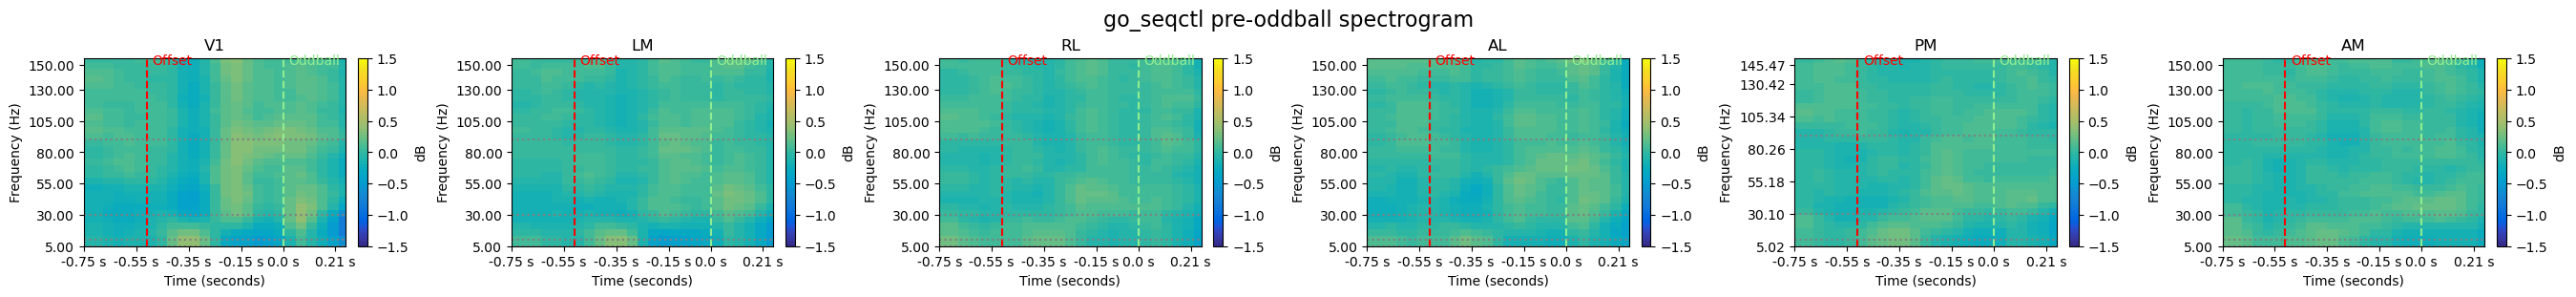

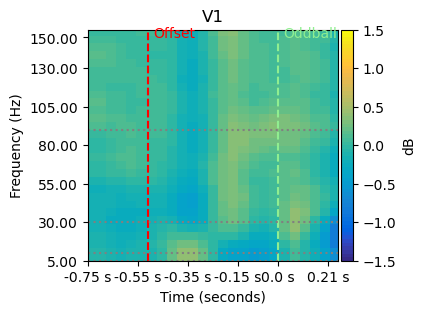

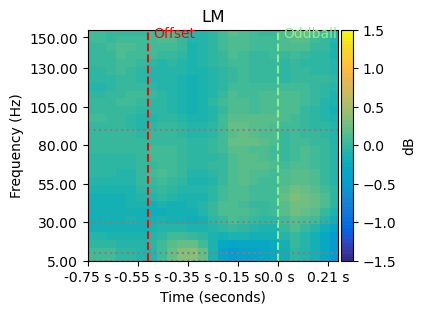

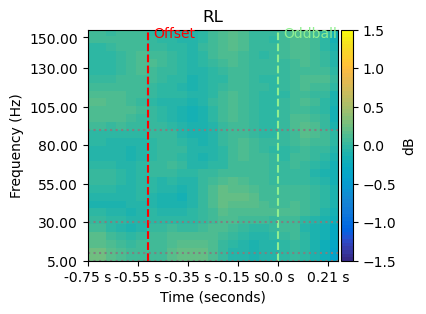

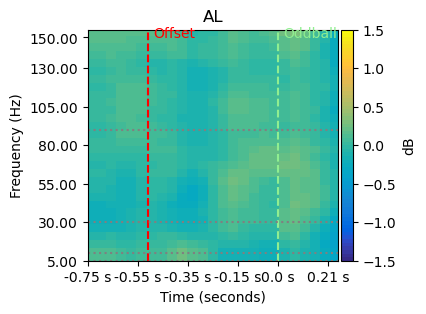

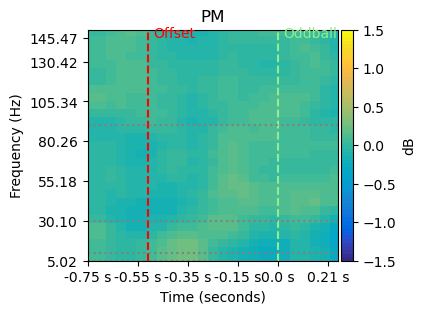

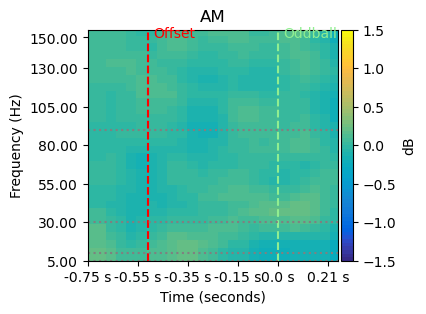

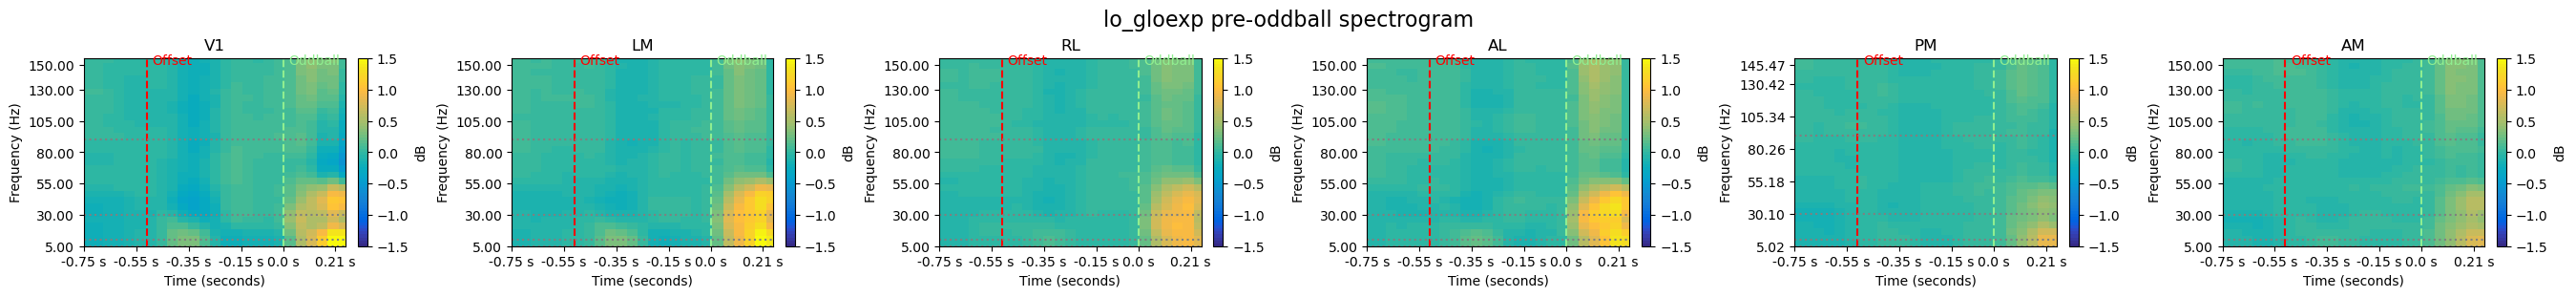

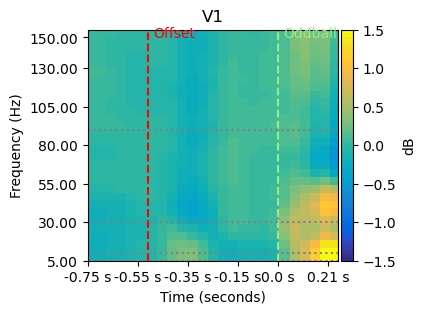

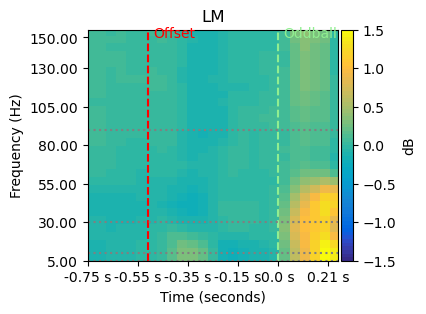

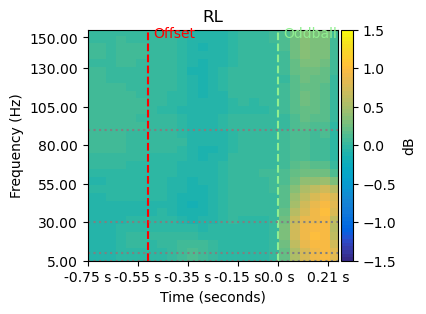

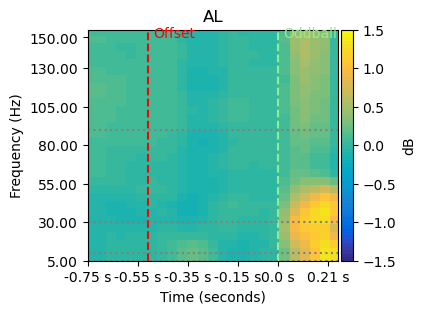

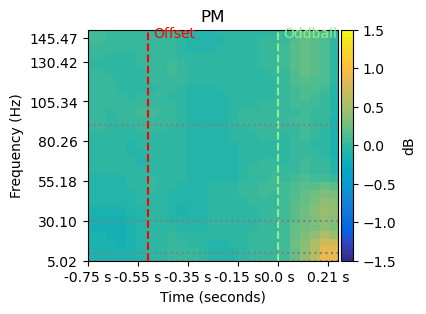

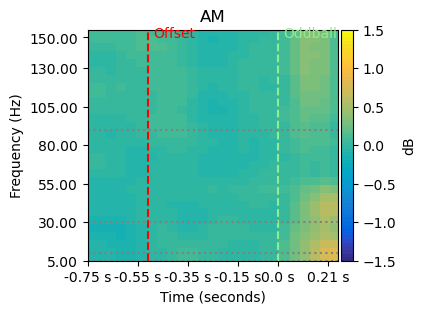

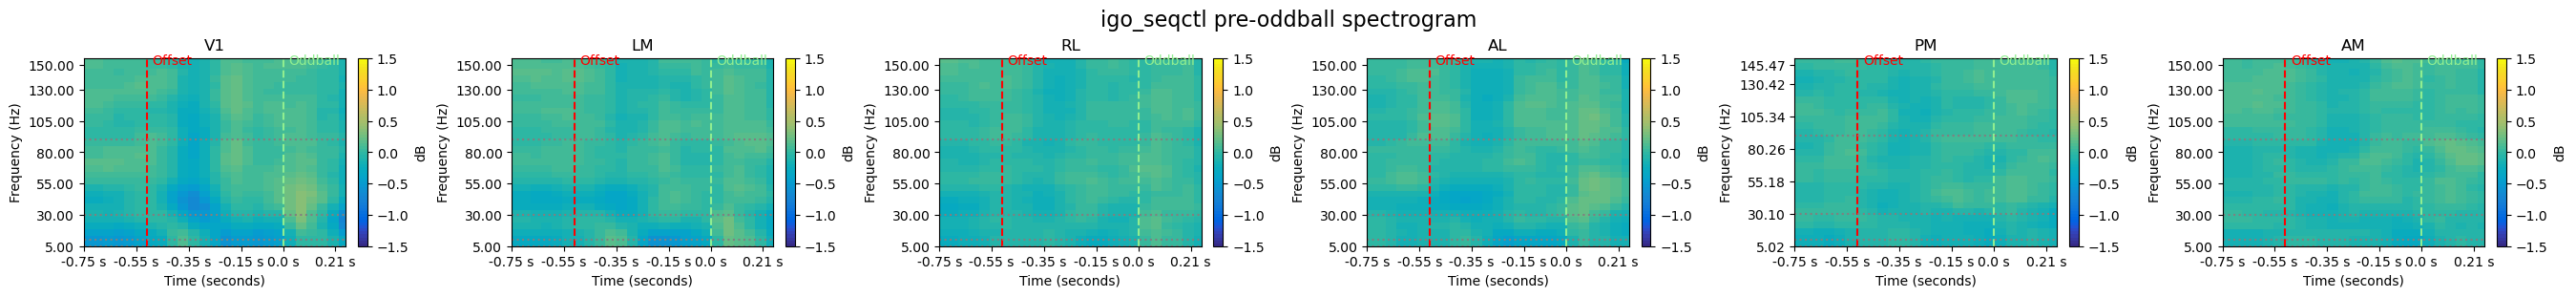

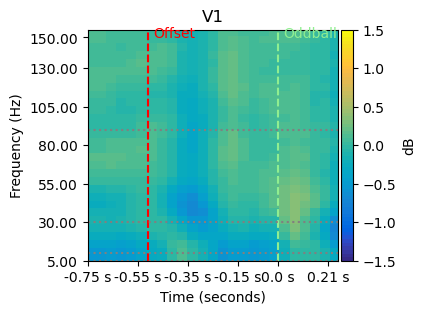

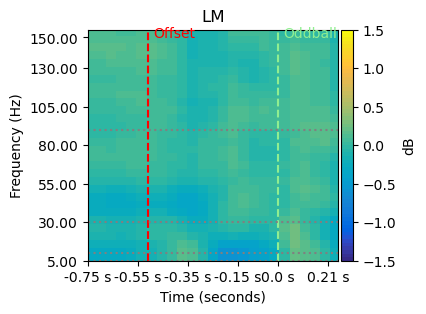

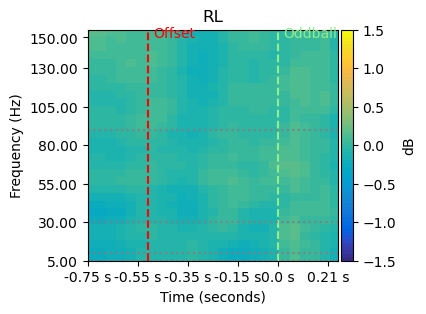

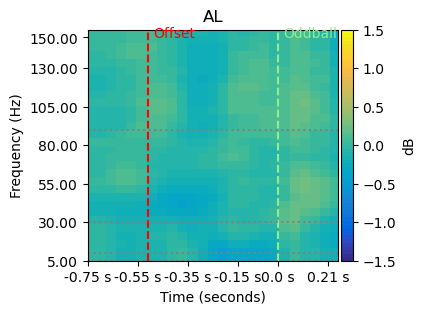

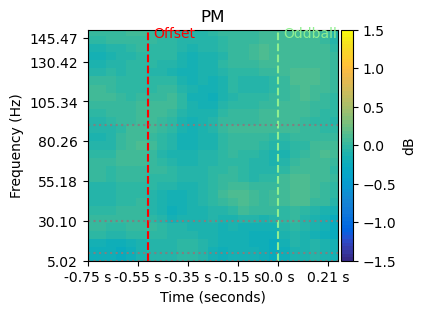

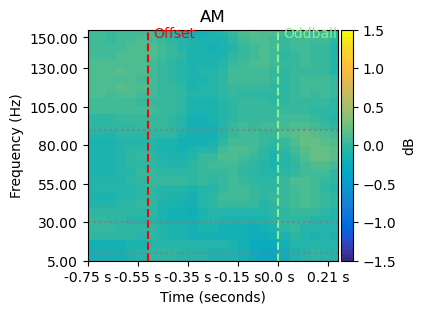

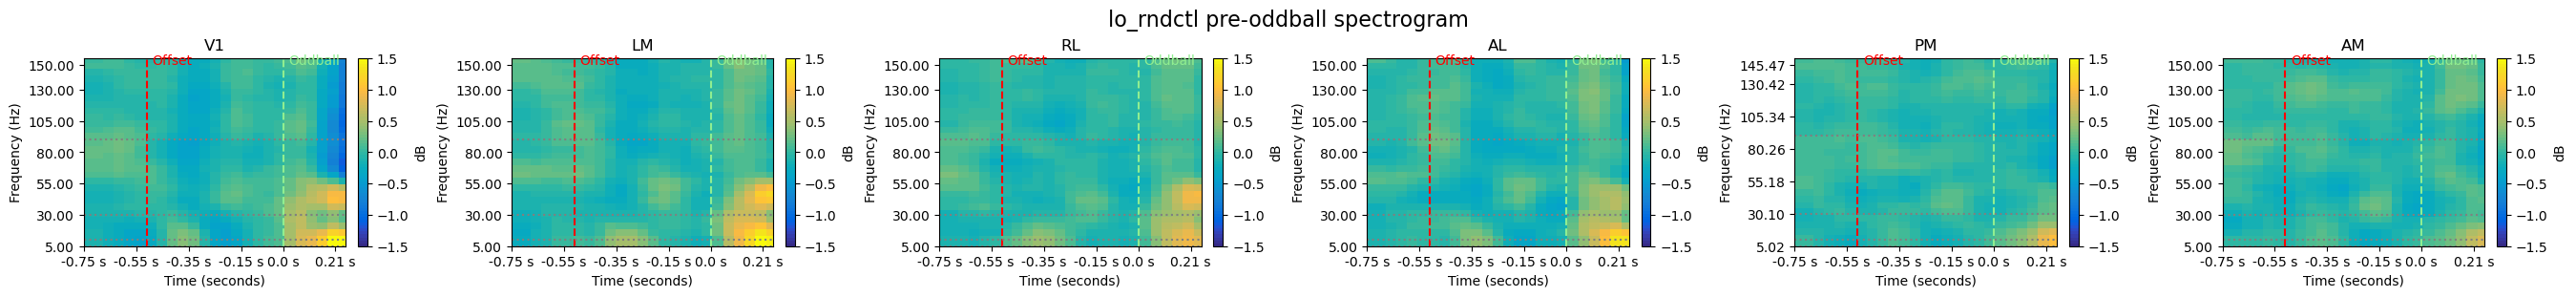

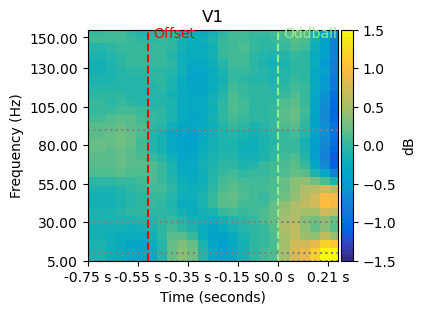

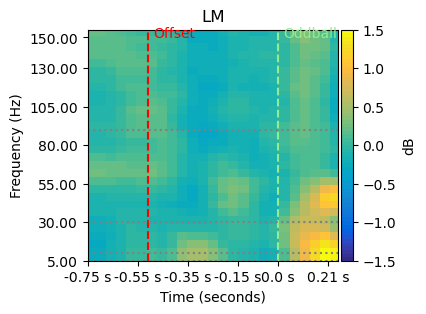

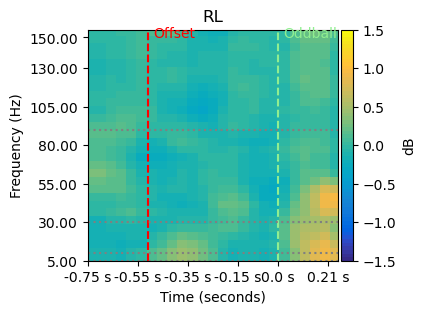

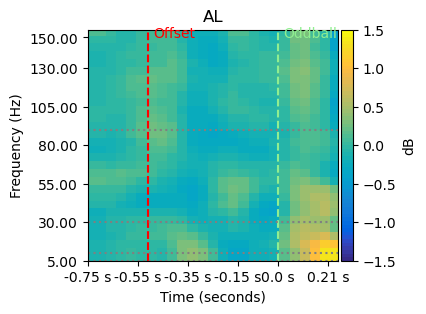

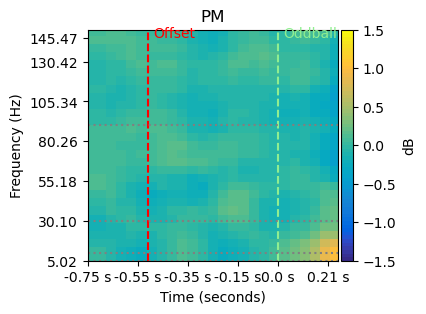

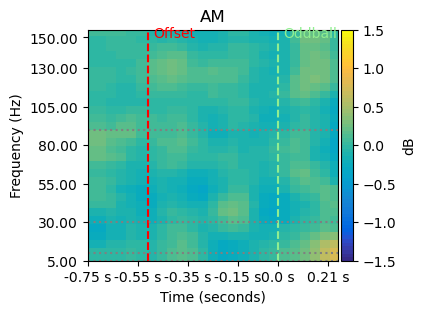

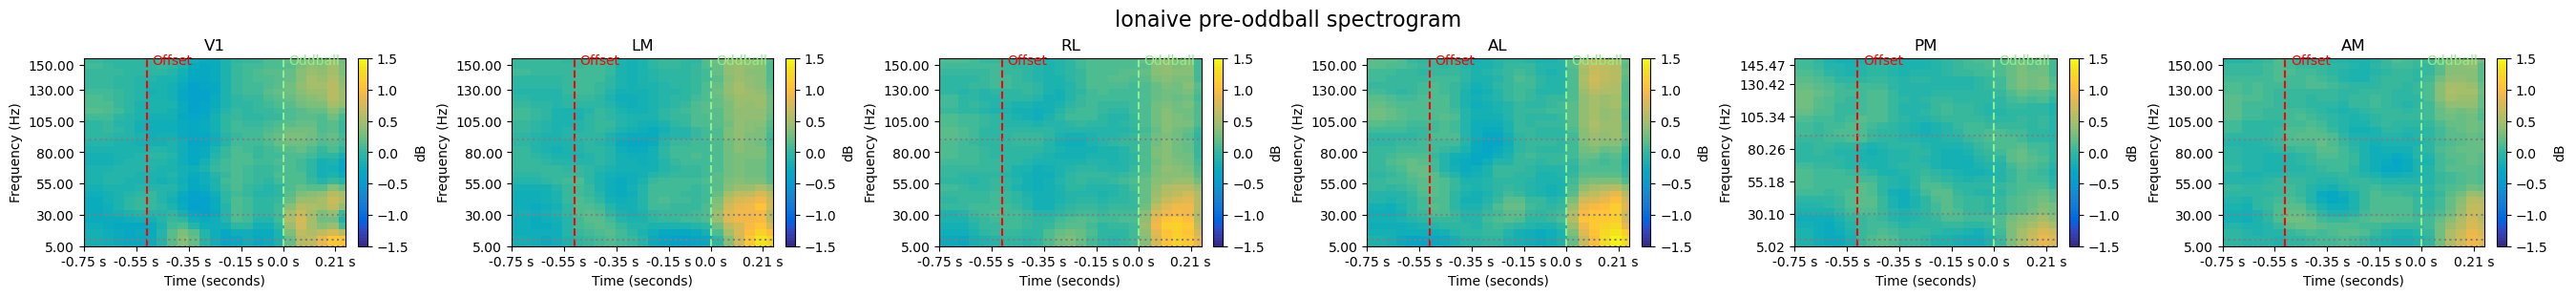

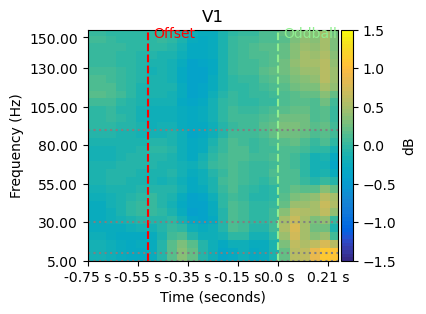

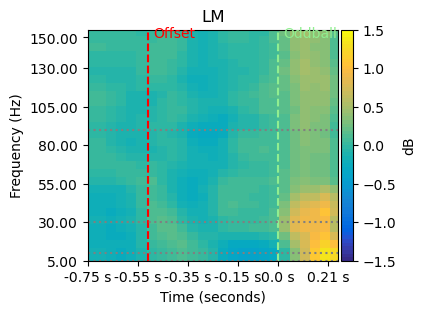

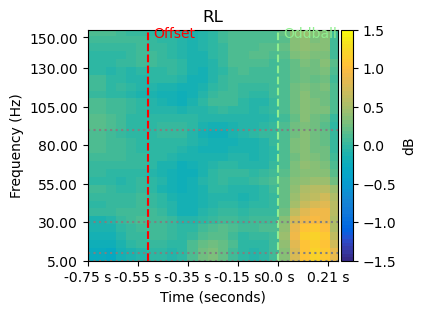

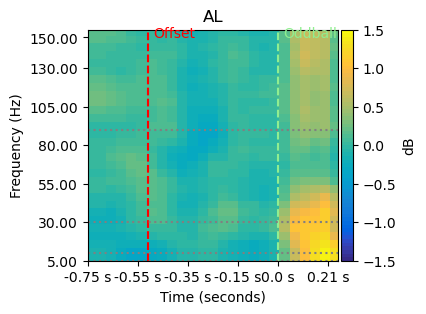

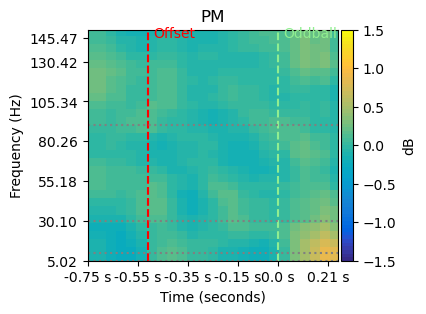

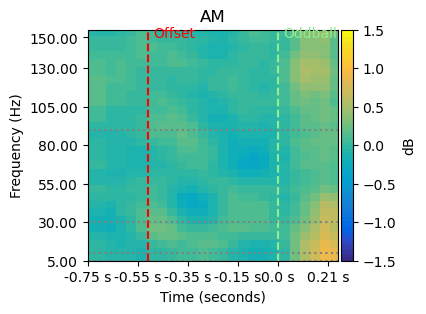

In [18]:
for cond in itertools.chain(*[[c1, c2] for (_, c1, c2) in CONTRASTS]):
    diffs = epych.recording.Sampling(epych.recording.empty_intervals(), spectrograms[cond]._trials, epych.recording.default_units(), **{
        k: prestimulus_4minus3(v.result()) for k, v in spectrograms[cond].stats.items()
    }).erp()
    diffs.plot(signals=anatomical_areas, sigtitle=stattitle, vmax=1.5, vmin=-1.5, title=cond + " pre-oddball spectrogram",
               figure="oscillatory_prestim_4-3_%s.pdf" % cond, **ADAPTED_EVENTS)
    for area in anatomical_areas:
        os.makedirs("oscillatory_prestim_4-3_%s/" % cond, exist_ok=True)
        diffs.signals[area].plot(title=area_titles[area], vmax=1.5, vmin=-1.5, filename="oscillatory_prestim_4-3_%s/%s.pdf" % (cond, area),
                                 **ADAPTED_EVENTS)

In [19]:
CONTRAST_VMAXES = {
    "go_contrast": 0.2,
    "ssa": 3,
    "dd": 0.75,
}

In [20]:
contrasts = {}
diffs = {}

In [21]:
def area_name(probe, signals):
    return probe

In [22]:
for (name, condl, condr) in CONTRASTS:
    contrast = epych.statistic.Summary(area_name, initialize_grand_cluster_test)
    contrast._trials = spectrograms[condl]._trials
    contrast_signals = {k: (oscillatory_4minus3(spectrograms[condl].stats[k].result()), oscillatory_4minus3(spectrograms[condr].stats[k].result()))
                        for k in spectrograms[condl].stats.keys()}
    contrast.calculate([contrast_signals])
    logging.info("Nonparametrically contrasted spectrograms for %s" % name)

    area_contrasts = contrast.results()
    diffs[name] = epych.recording.EvokedSampling(epych.recording.empty_intervals(), epych.recording.empty_trials(), epych.recording.default_units(), **{
        k: v['signal'] for k, v in area_contrasts.items()
    })
    contrasts[name] = diffs[name].smap(lambda k, sig: sig.fmap(lambda data: data * area_contrasts[k]['mask']), keys=True)

    contrasts[name].pickle("/mnt/data/000253/oscillatory_contrasts_4-3_" + name + '_05')

INFO:root:Nonparametrically contrasted spectrograms for go_contrast
INFO:root:Nonparametrically contrasted spectrograms for ssa
INFO:root:Nonparametrically contrasted spectrograms for dd


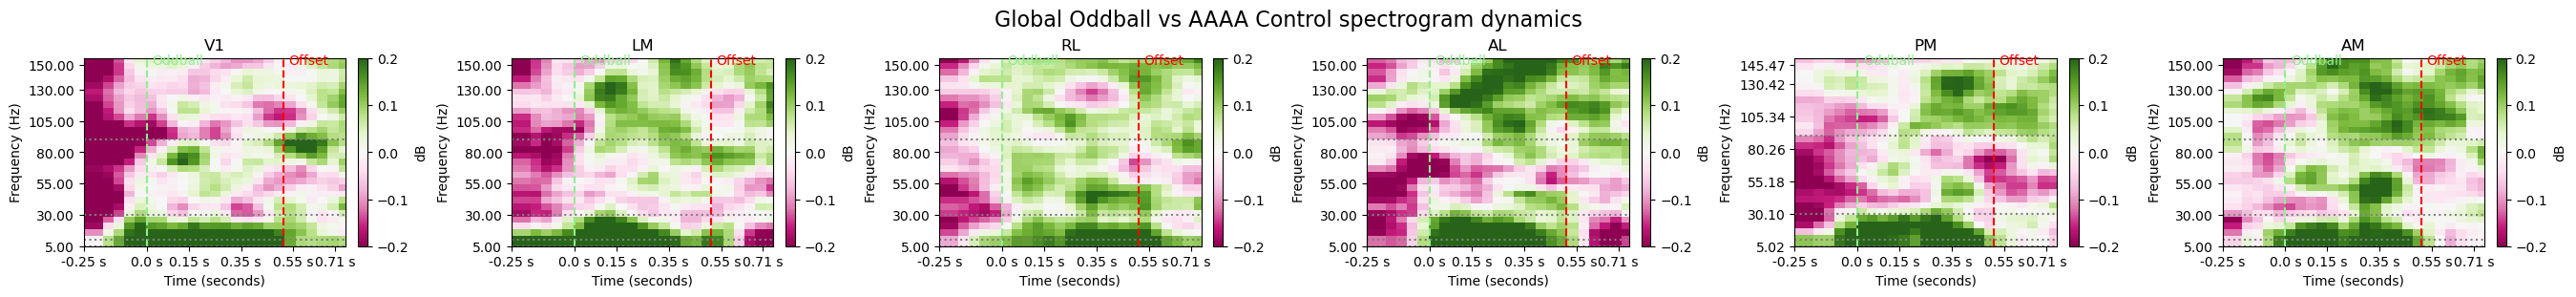

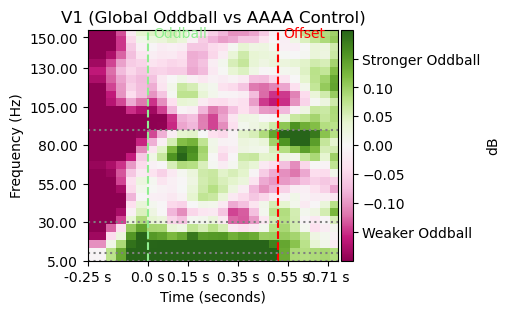

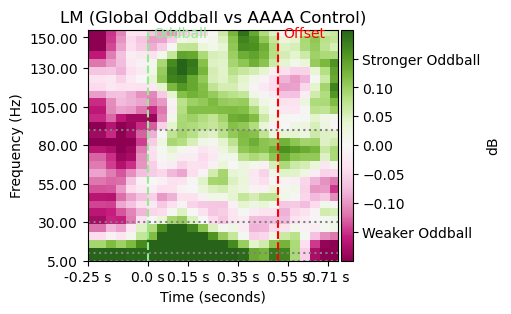

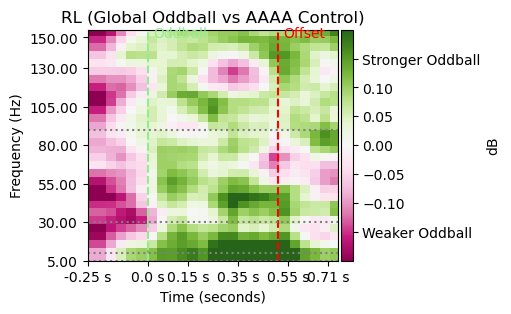

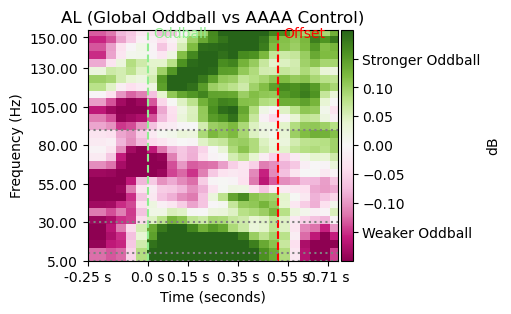

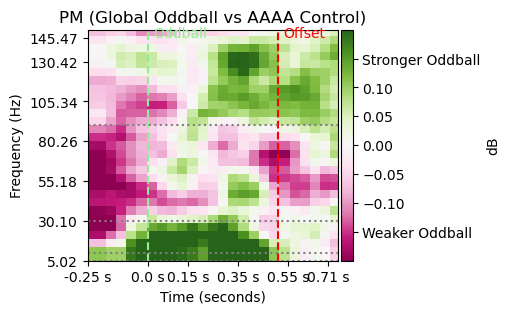

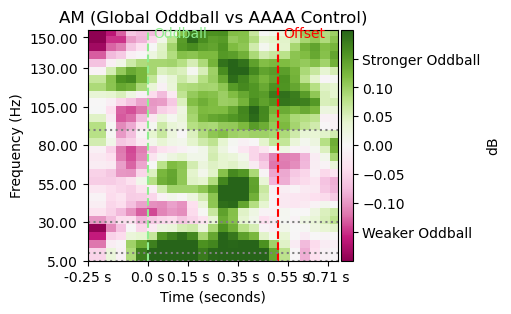

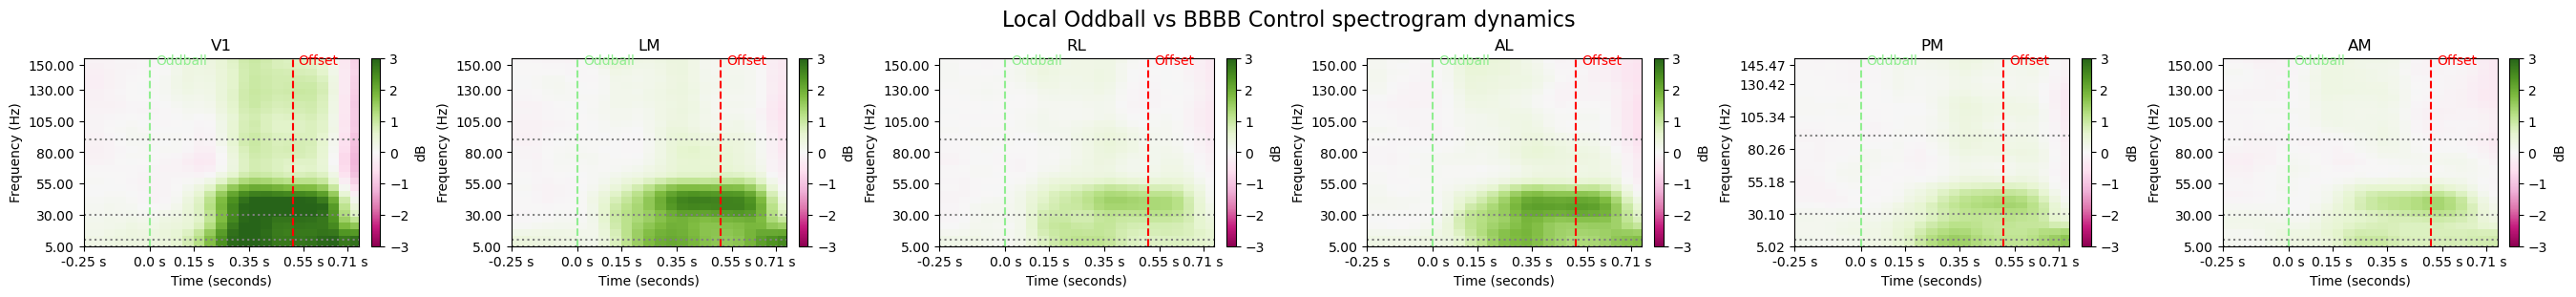

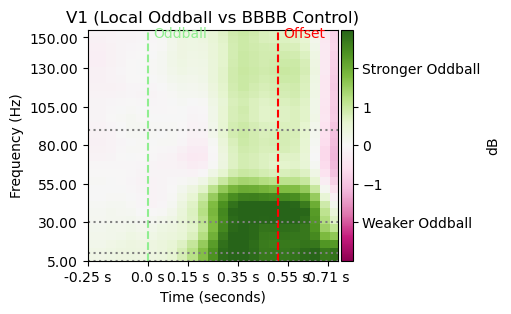

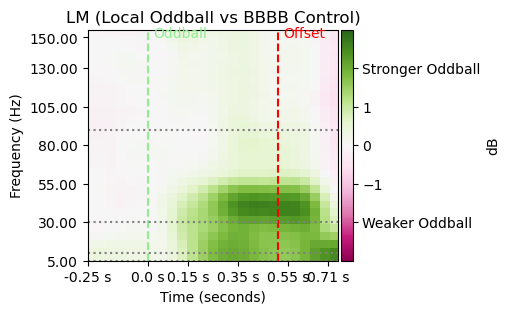

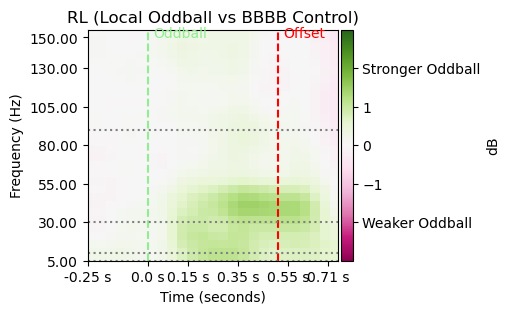

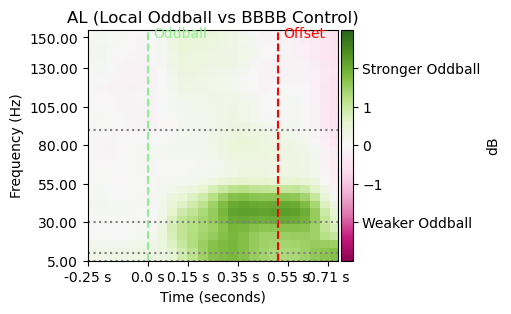

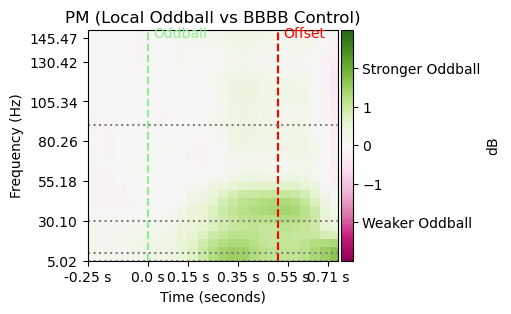

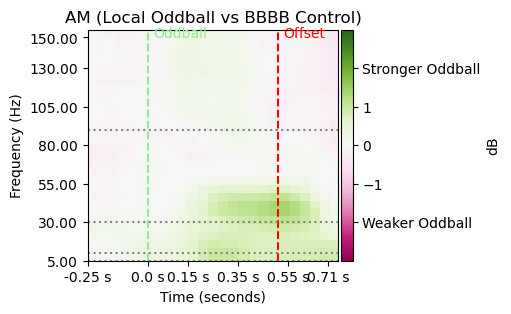

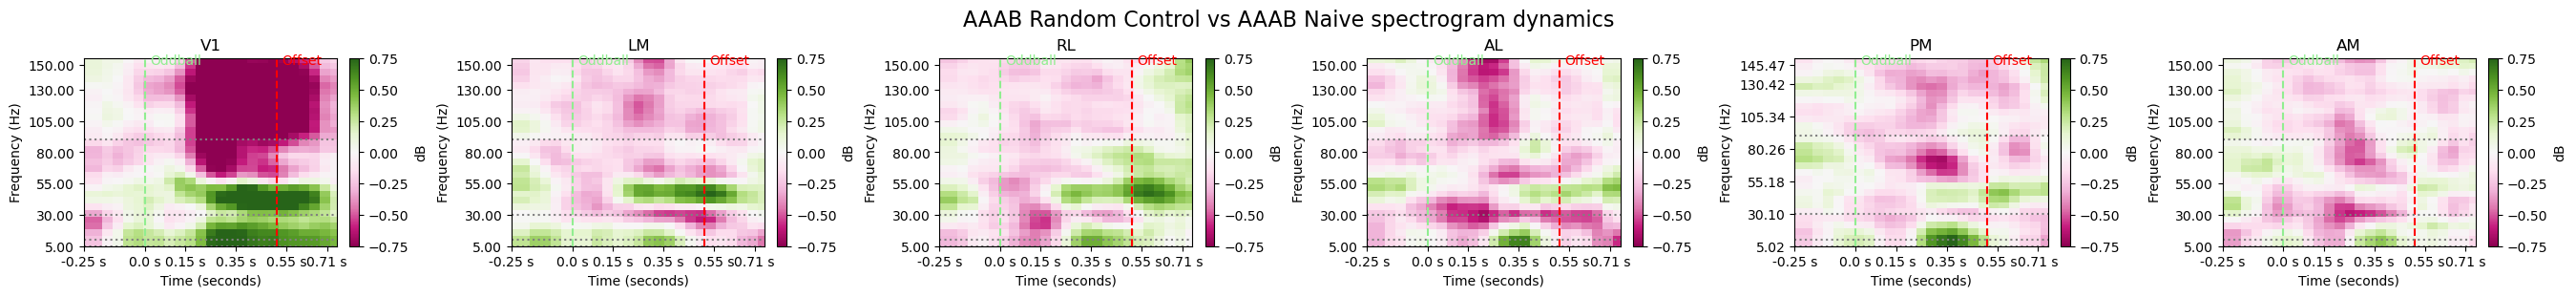

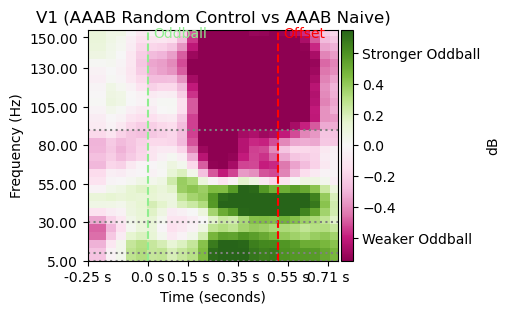

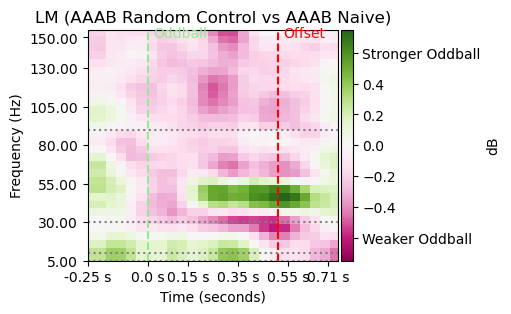

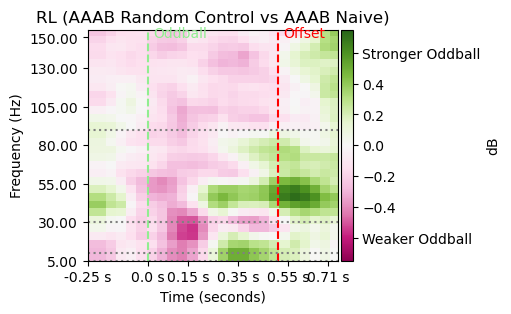

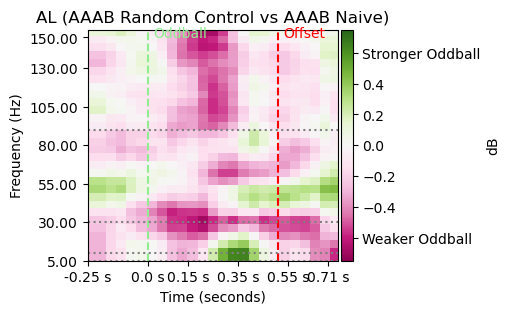

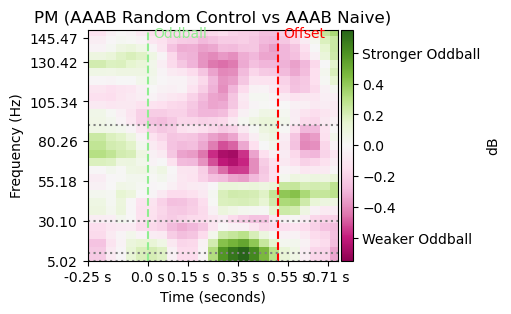

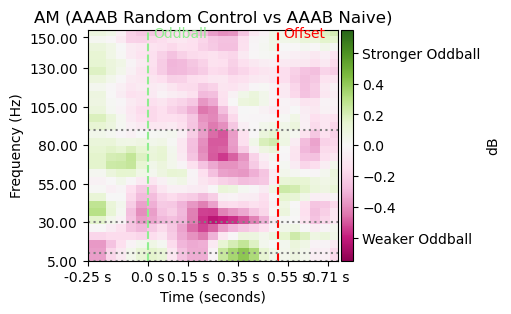

In [23]:
for (name, _, _) in CONTRASTS:
    diff_title = functools.partial(contrast_stattitle, name)
    diff_tfrs = diffs[name]
    diff_tfrs.plot(signals=anatomical_areas, sigtitle=stattitle, cmap='PiYG', vmax=CONTRAST_VMAXES[name], vmin=-CONTRAST_VMAXES[name], title=CONTRAST_TITLES[name] + " spectrogram dynamics",
                   figure="oscillatory_diffs_4-3_%s_05.pdf" % name, **EVENTS)
    for area in anatomical_areas:
        os.makedirs("oscillatory_diffs_4-3_%s_05/" % name, exist_ok=True)
        diff_tfrs.signals[area].plot(title=diff_title(area, diffs[name].signals[area]), cmap='PiYG', vmax=CONTRAST_VMAXES[name], vmin=-CONTRAST_VMAXES[name],
                                     filename="oscillatory_diffs_4-3_%s_05/%s.pdf" % (name, area), cbar_ends=("Stronger Oddball", "Weaker Oddball"), **EVENTS)

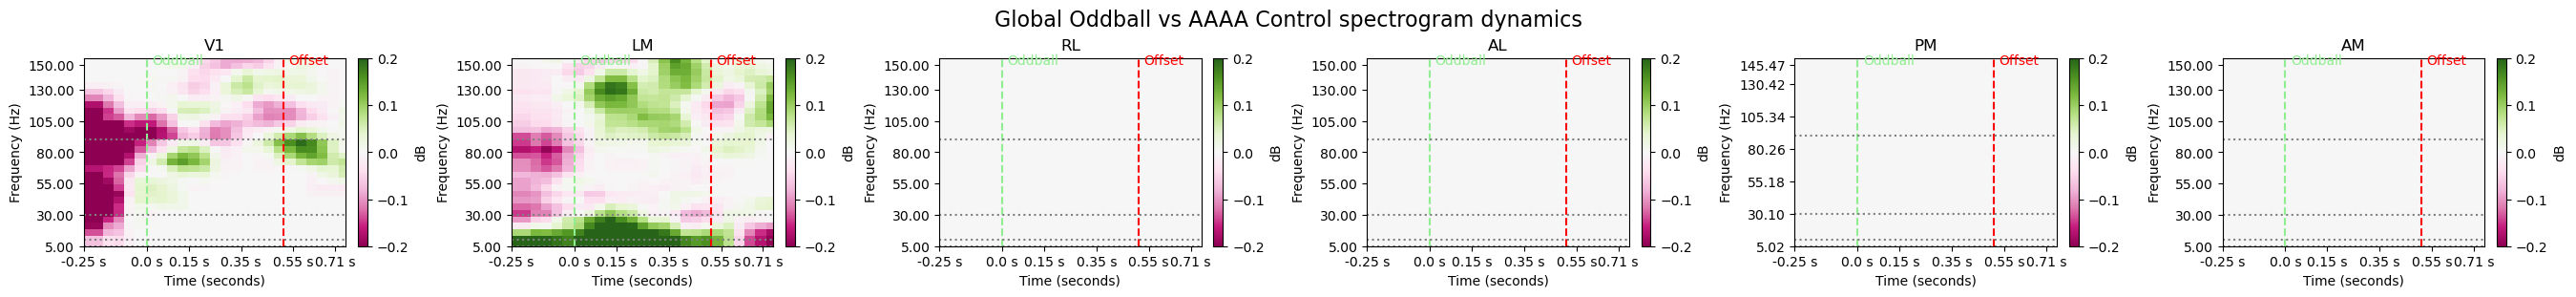

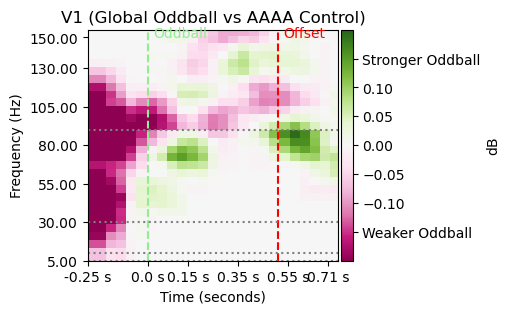

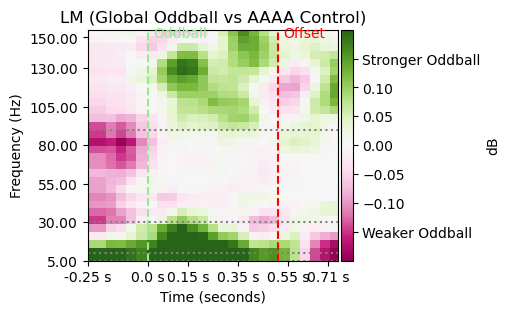

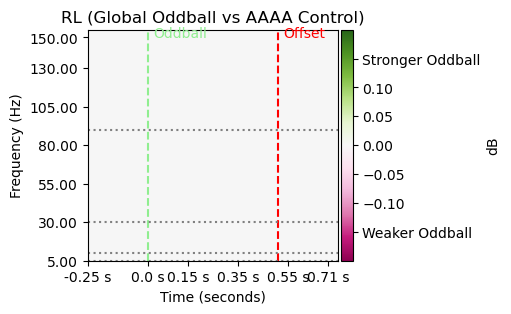

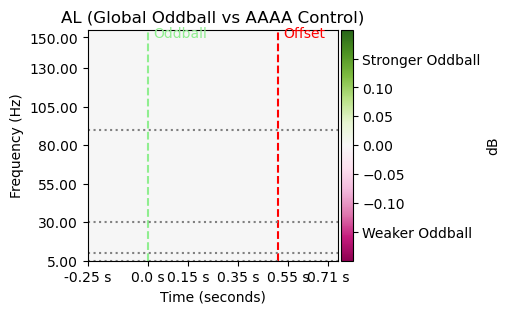

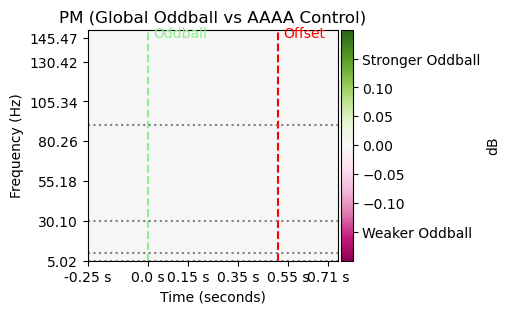

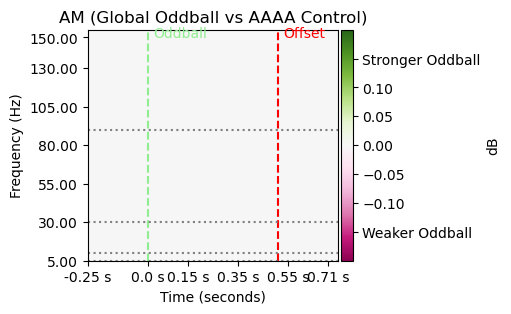

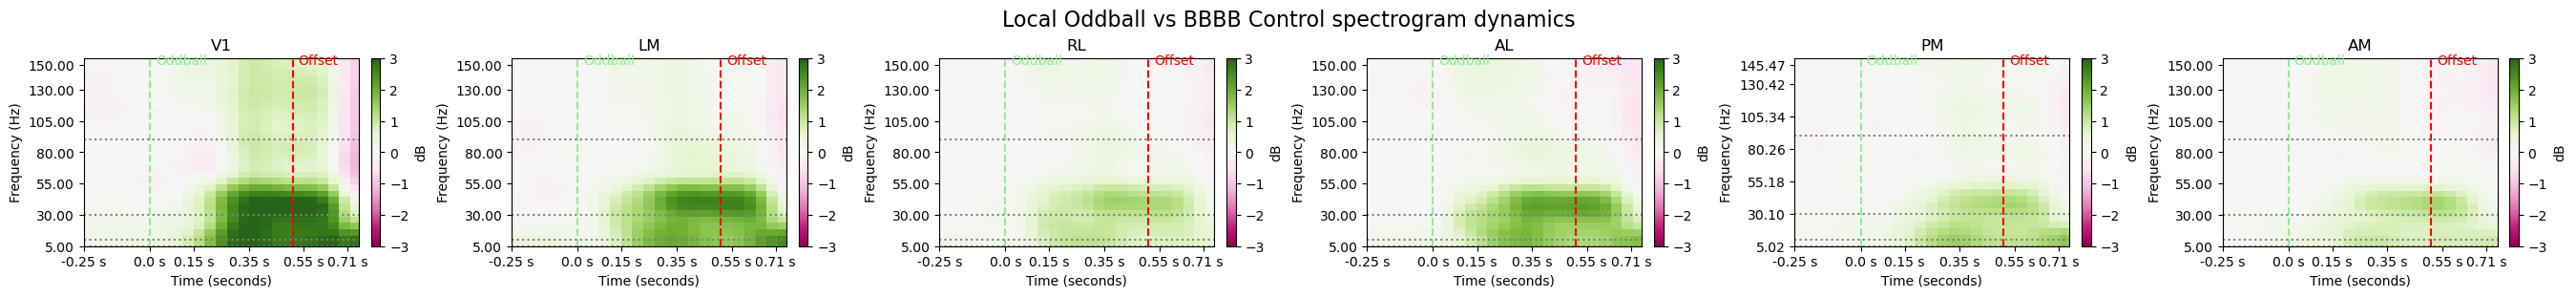

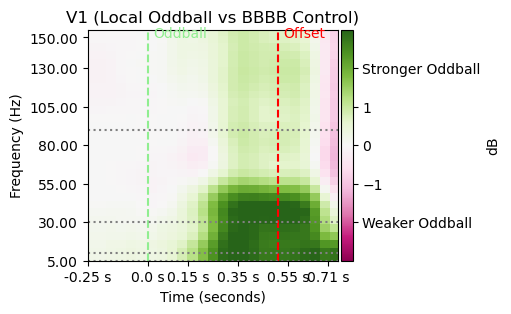

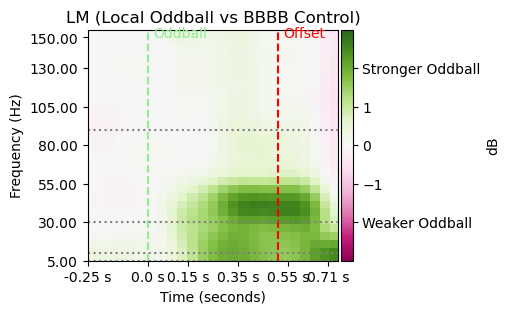

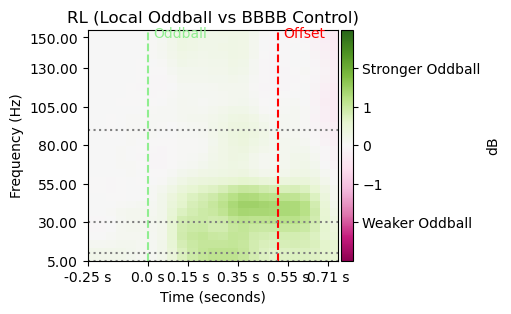

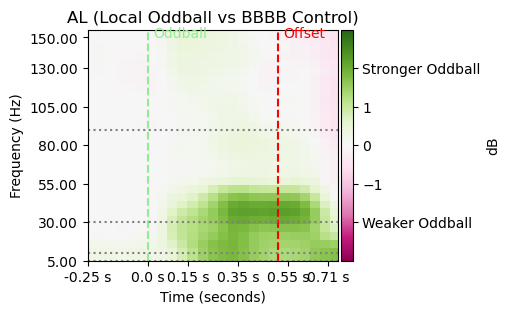

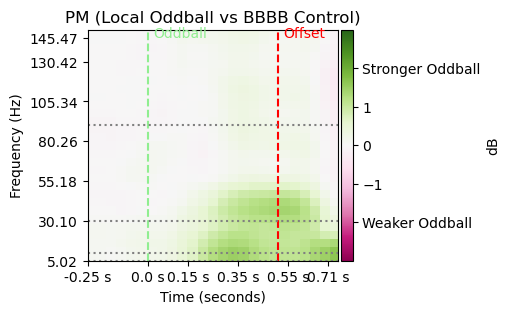

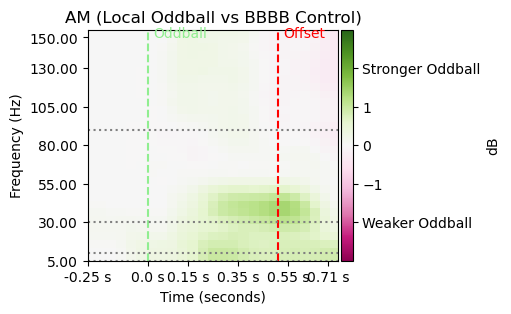

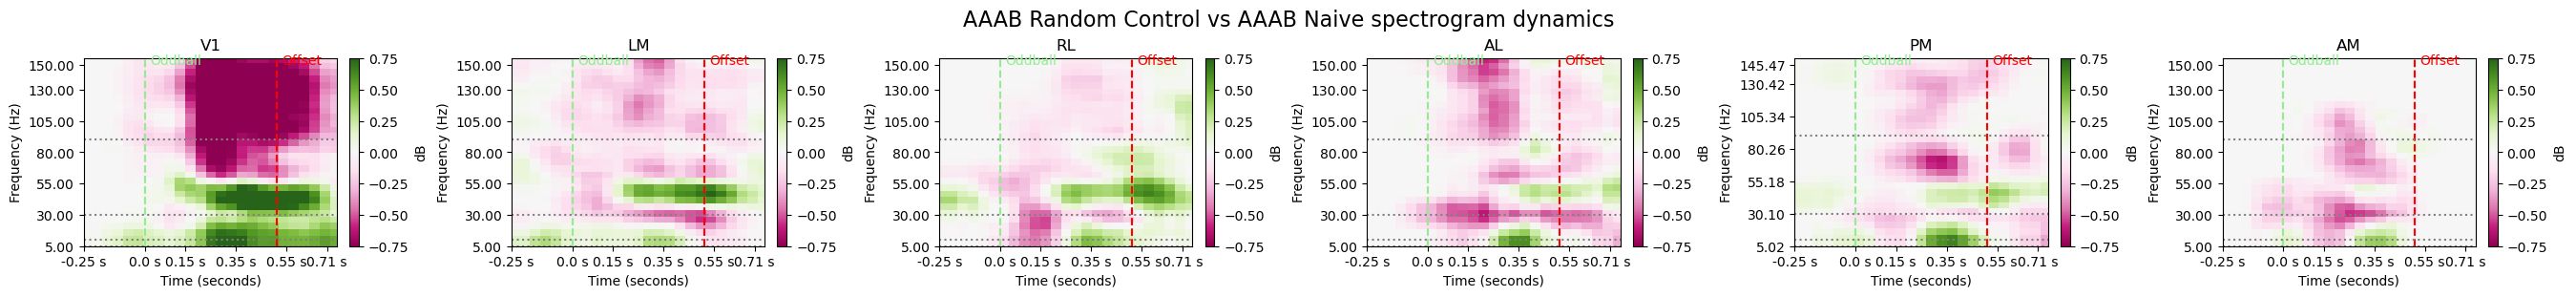

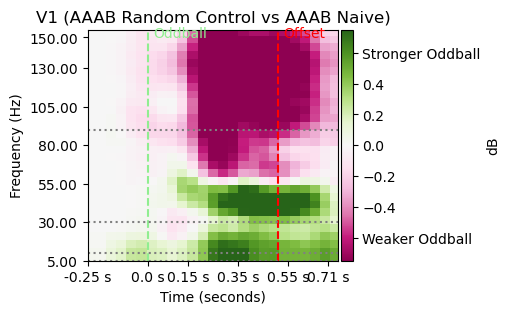

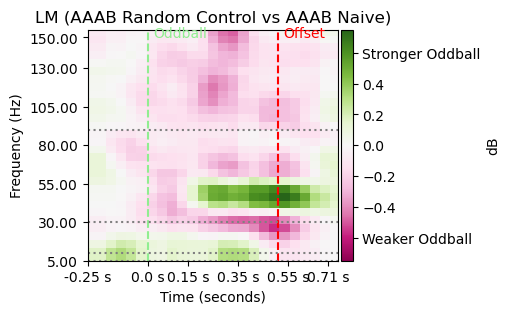

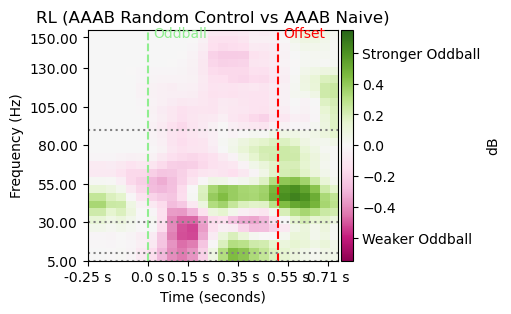

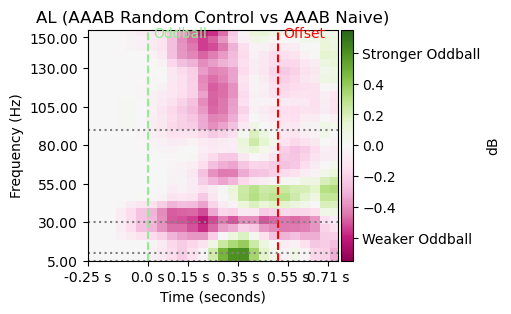

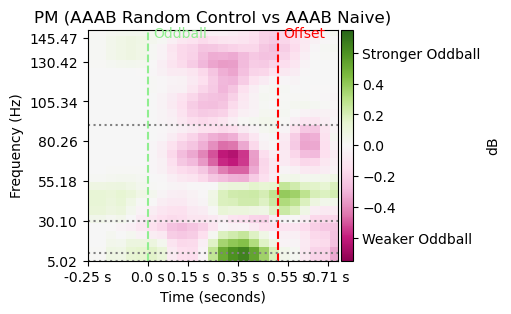

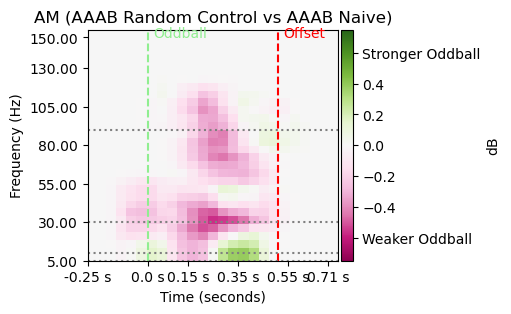

In [24]:
for (name, _, _) in CONTRASTS:
    contrast_title = functools.partial(contrast_stattitle, name)
    contrast_tfrs = contrasts[name]
    contrast_tfrs.plot(signals=anatomical_areas, sigtitle=stattitle, cmap='PiYG', vmax=CONTRAST_VMAXES[name], vmin=-CONTRAST_VMAXES[name], title=CONTRAST_TITLES[name] + " spectrogram dynamics",
                       figure="oscillatory_contrasts_4-3_%s_05.pdf" % name, **EVENTS)
    for area in anatomical_areas:
        os.makedirs("oscillatory_contrasts_4-3_%s_05/" % name, exist_ok=True)
        contrast_tfrs.signals[area].plot(title=contrast_title(area, contrasts[name].signals[area]), cmap='PiYG', vmax=CONTRAST_VMAXES[name], vmin=-CONTRAST_VMAXES[name],
                                         filename="oscillatory_contrasts_4-3_%s_05/%s.pdf" % (name, area), cbar_ends=("Stronger Oddball", "Weaker Oddball"), **EVENTS)

In [25]:
for (name, condl, condr) in CONTRASTS:
    contrast = epych.statistic.Summary(area_name, initialize_grand_cluster_test)
    contrast._trials = spectrograms[condl]._trials
    contrast_signals = {k: (prestimulus_4minus3(spectrograms[condl].stats[k].result()), prestimulus_4minus3(spectrograms[condr].stats[k].result()))
                        for k in spectrograms[condl].stats.keys()}
    contrast.calculate([contrast_signals])
    logging.info("Nonparametrically contrasted pre-oddball spectrograms for %s" % name)

    area_contrasts = contrast.results()
    diffs[name] = epych.recording.EvokedSampling(epych.recording.empty_intervals(), epych.recording.empty_trials(), epych.recording.default_units(), **{
        k: v['signal'] for k, v in area_contrasts.items()
    })
    contrasts[name] = diffs[name].smap(lambda k, sig: sig.fmap(lambda data: data * area_contrasts[k]['mask']), keys=True)

    contrasts[name].pickle("/mnt/data/000253/oscillatory_prestim_contrasts_4-3_" + name + '_05')

INFO:root:Nonparametrically contrasted pre-oddball spectrograms for go_contrast
INFO:root:Nonparametrically contrasted pre-oddball spectrograms for ssa
INFO:root:Nonparametrically contrasted pre-oddball spectrograms for dd


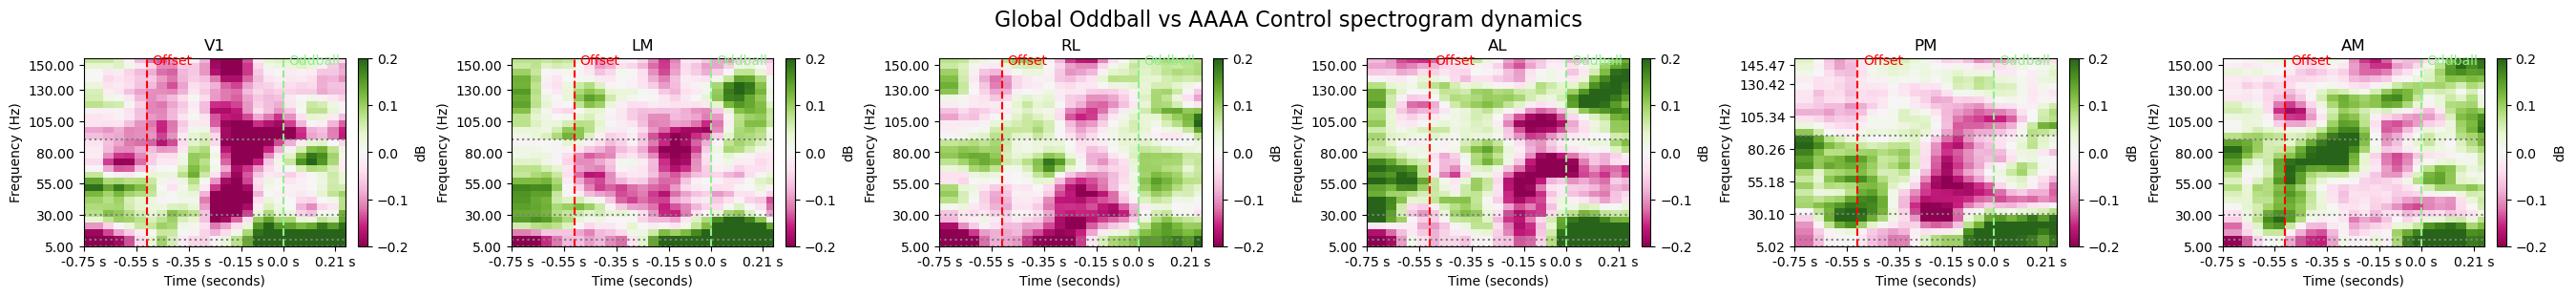

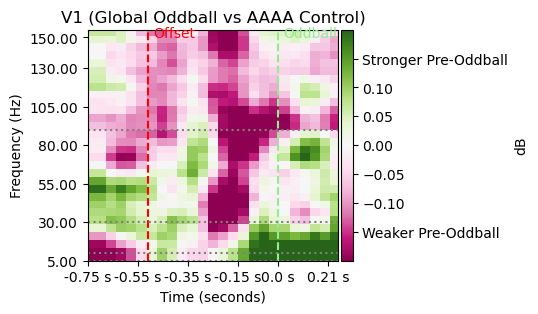

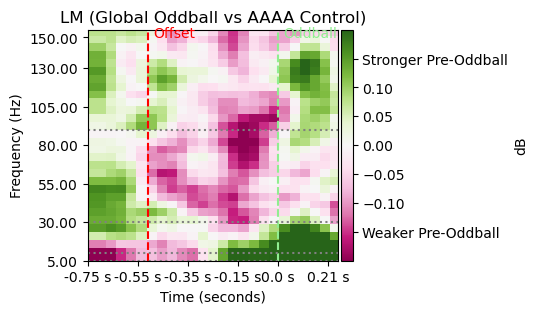

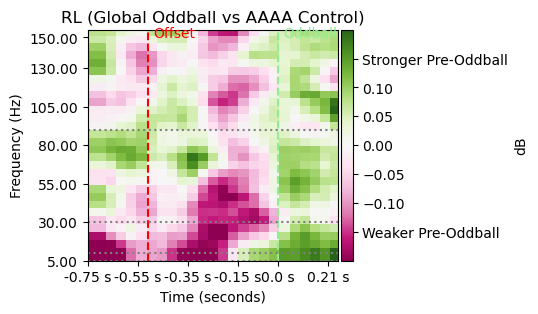

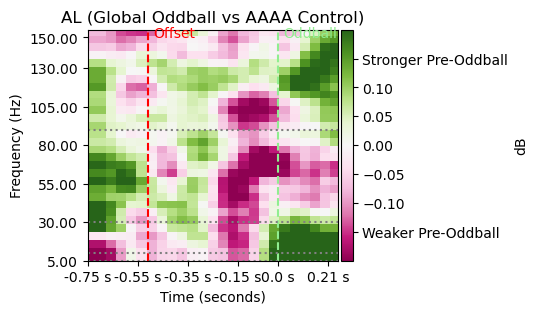

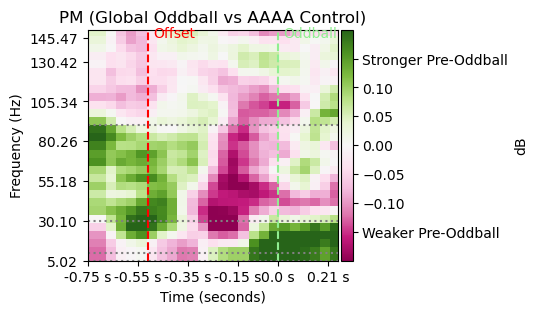

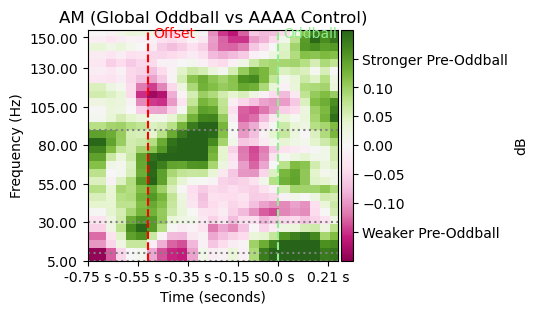

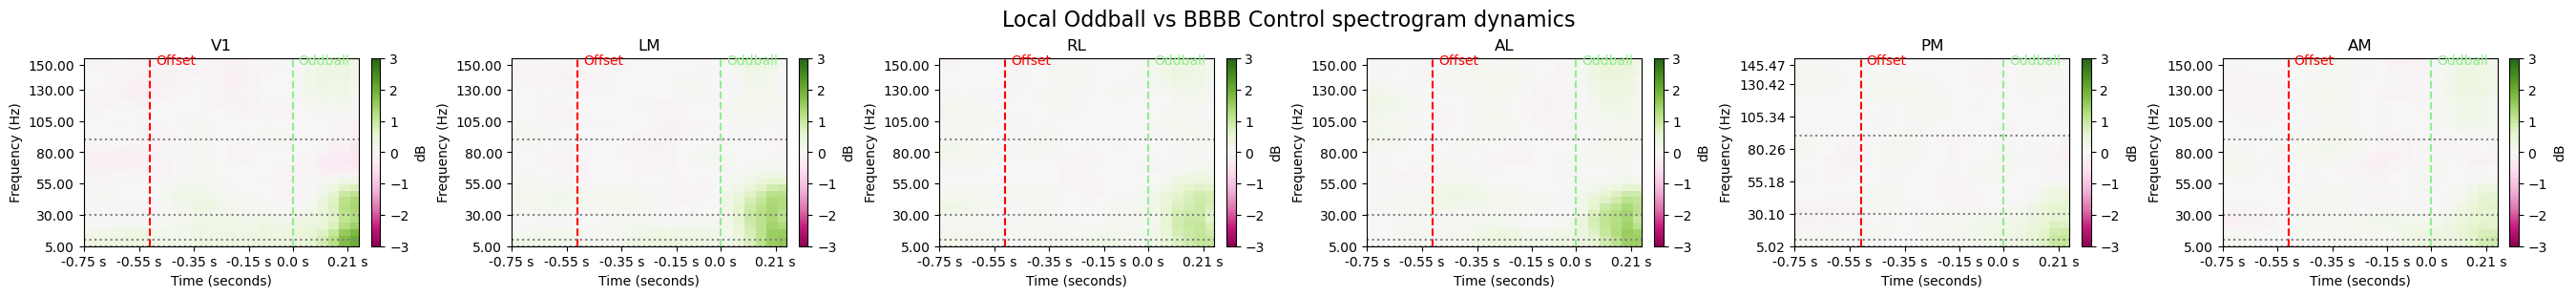

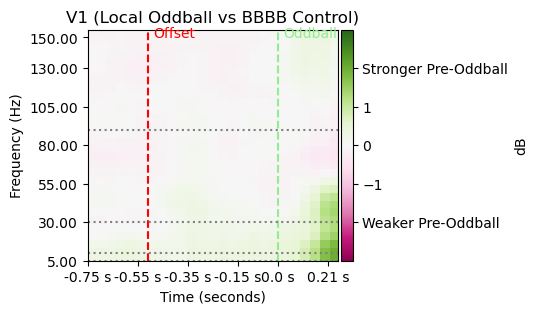

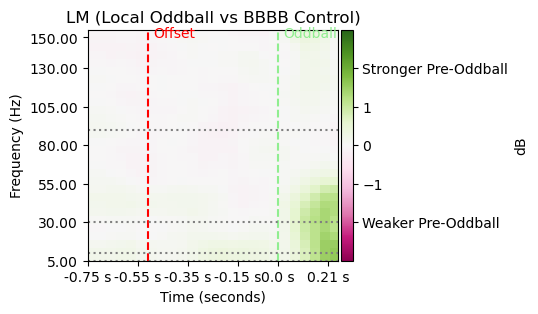

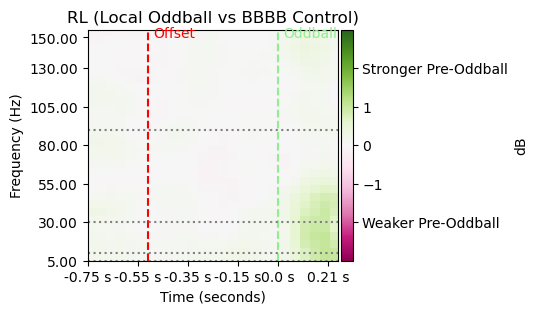

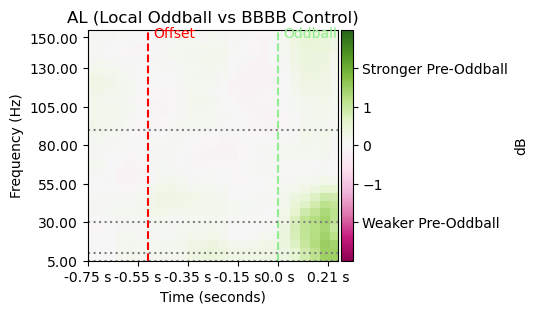

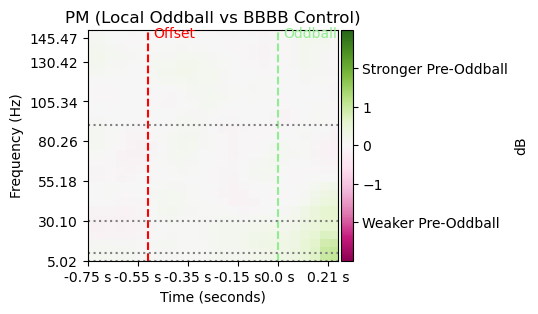

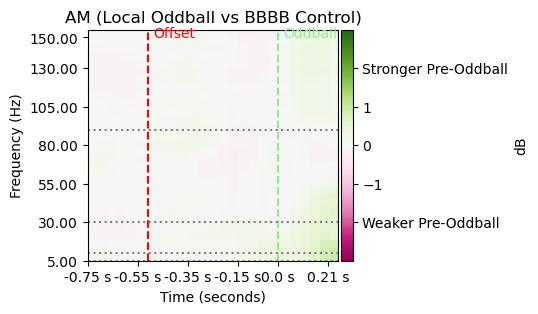

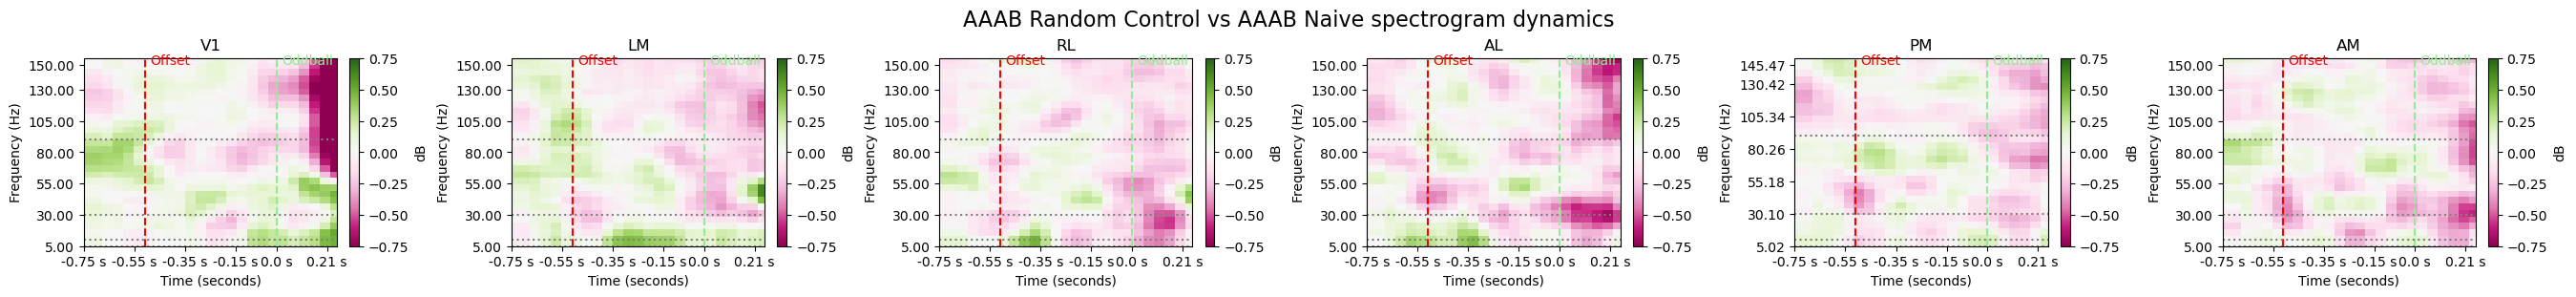

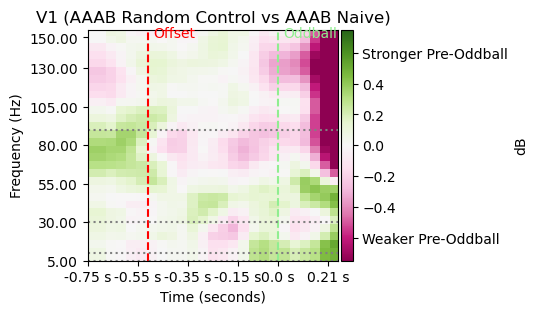

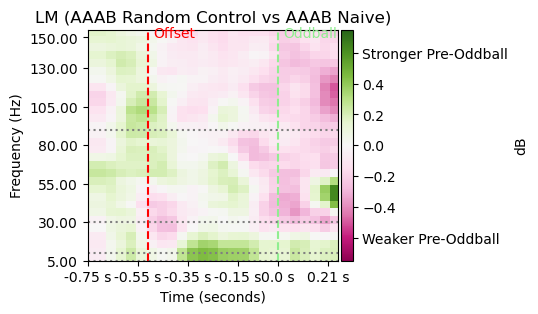

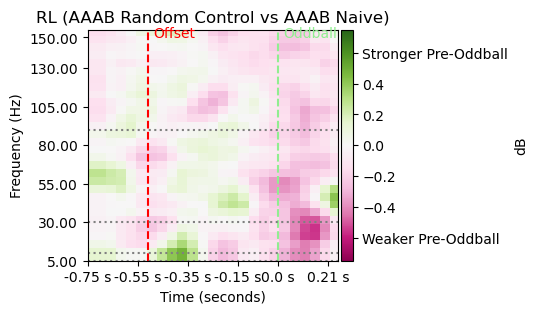

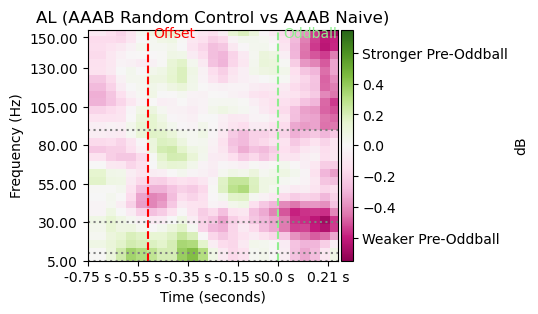

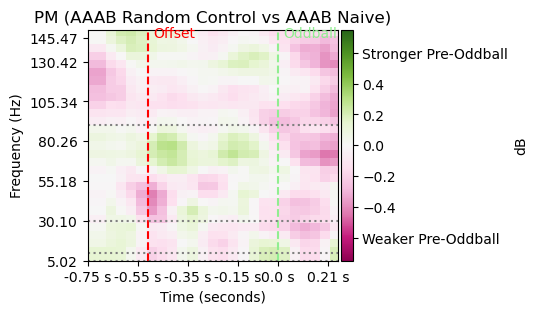

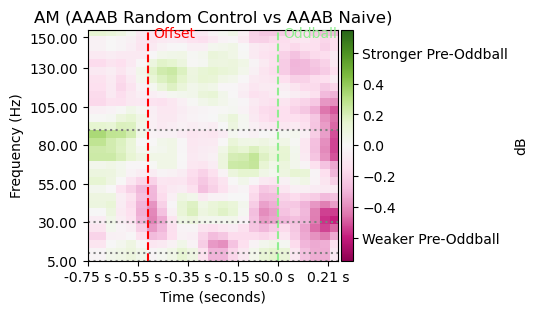

In [26]:
for (name, _, _) in CONTRASTS:
    diff_title = functools.partial(contrast_stattitle, name)
    diff_tfrs = diffs[name]
    diff_tfrs.plot(signals=anatomical_areas, sigtitle=stattitle, cmap='PiYG', vmax=CONTRAST_VMAXES[name], vmin=-CONTRAST_VMAXES[name], title=CONTRAST_TITLES[name] + " spectrogram dynamics",
                   figure="oscillatory_prestim_diffs_4-3_%s_05.pdf" % name, **ADAPTED_EVENTS)
    for area in anatomical_areas:
        os.makedirs("oscillatory_prestim_diffs_4-3_%s_05/" % name, exist_ok=True)
        diff_tfrs.signals[area].plot(title=diff_title(area, diffs[name].signals[area]), cmap='PiYG', vmax=CONTRAST_VMAXES[name], vmin=-CONTRAST_VMAXES[name],
                                     filename="oscillatory_prestim_diffs_4-3_%s_05/%s.pdf" % (name, area), cbar_ends=("Stronger Pre-Oddball", "Weaker Pre-Oddball"), **ADAPTED_EVENTS)

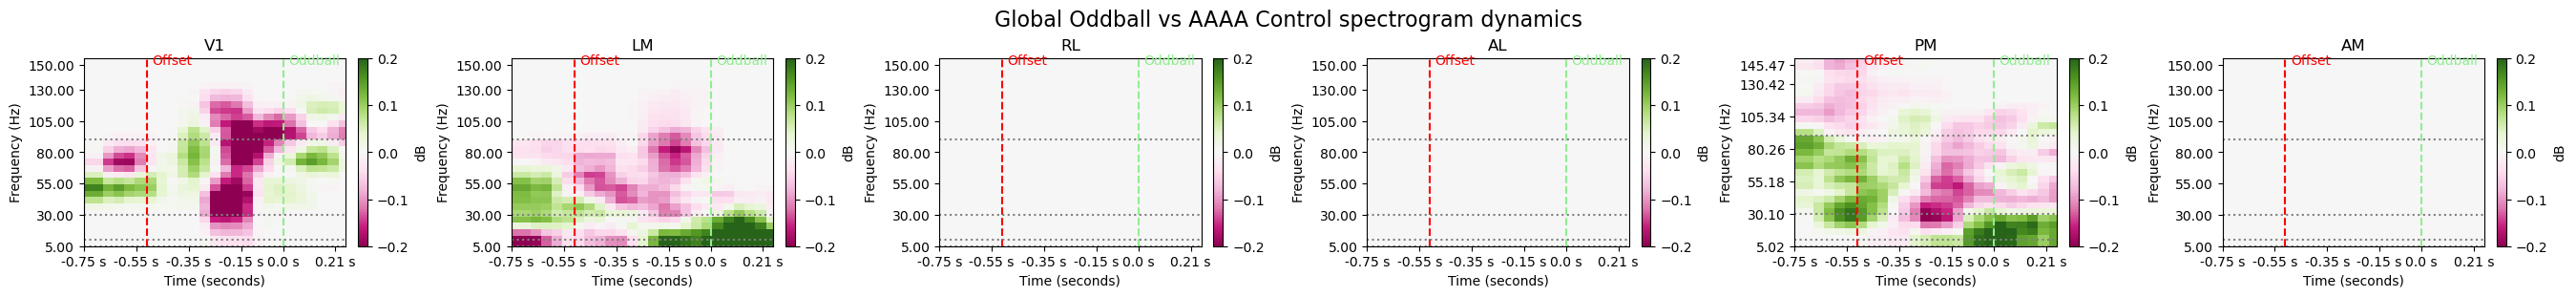

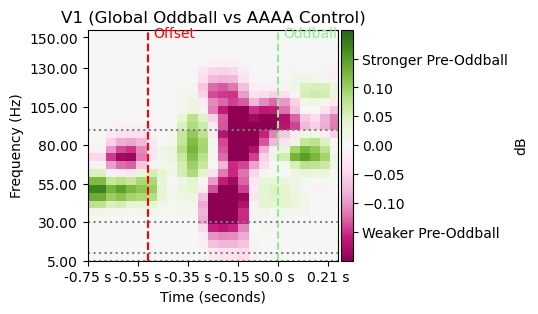

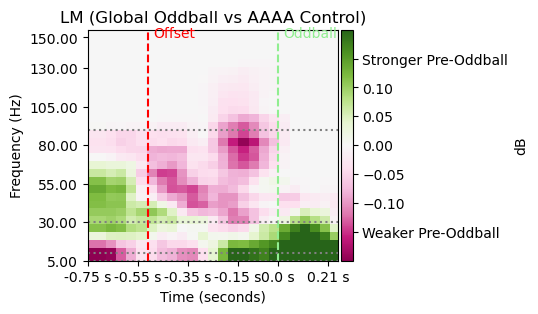

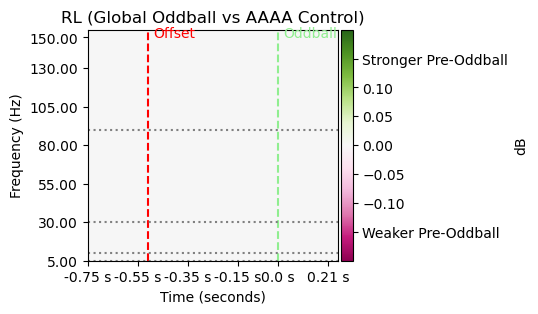

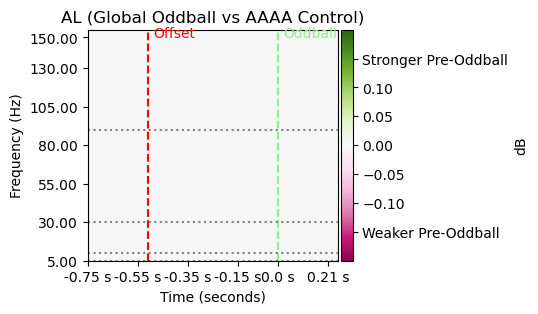

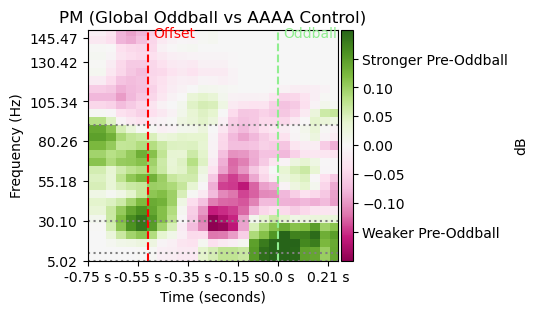

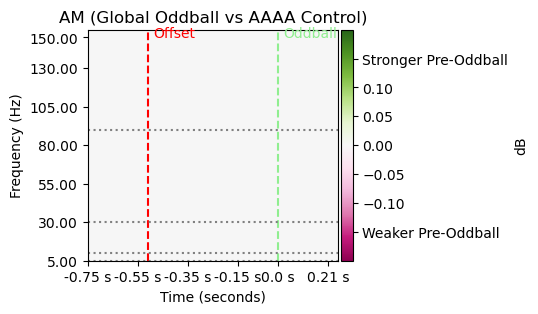

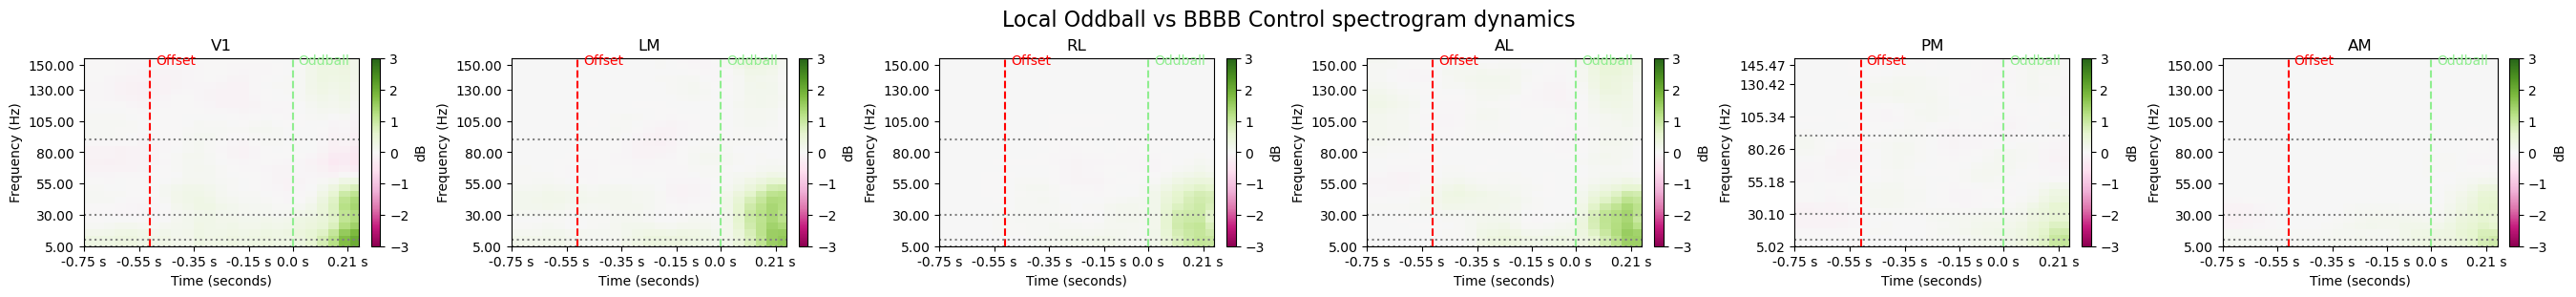

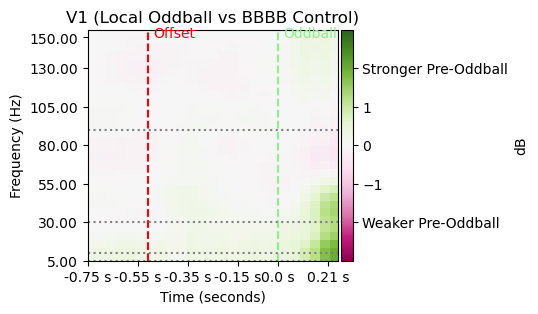

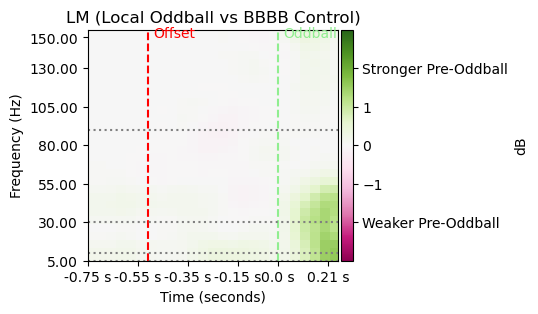

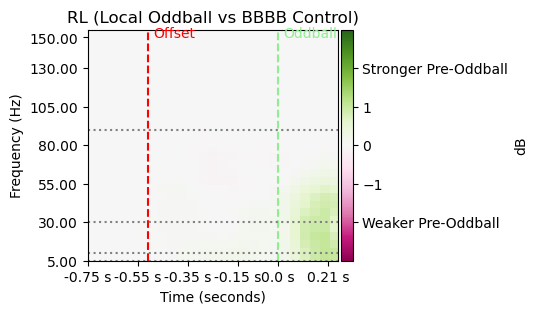

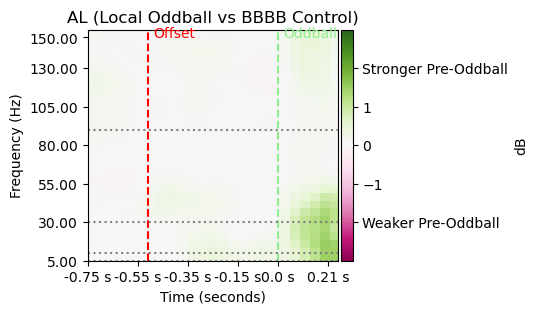

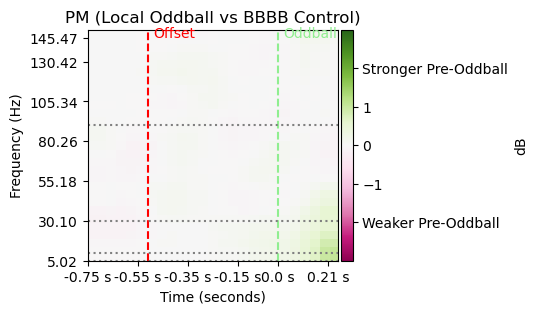

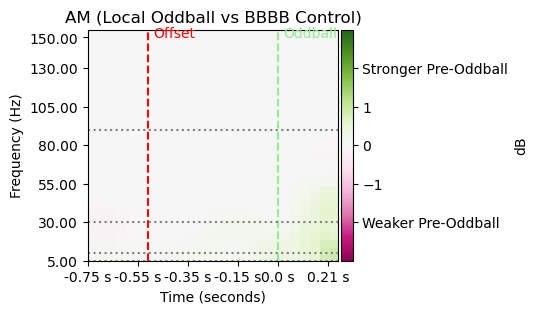

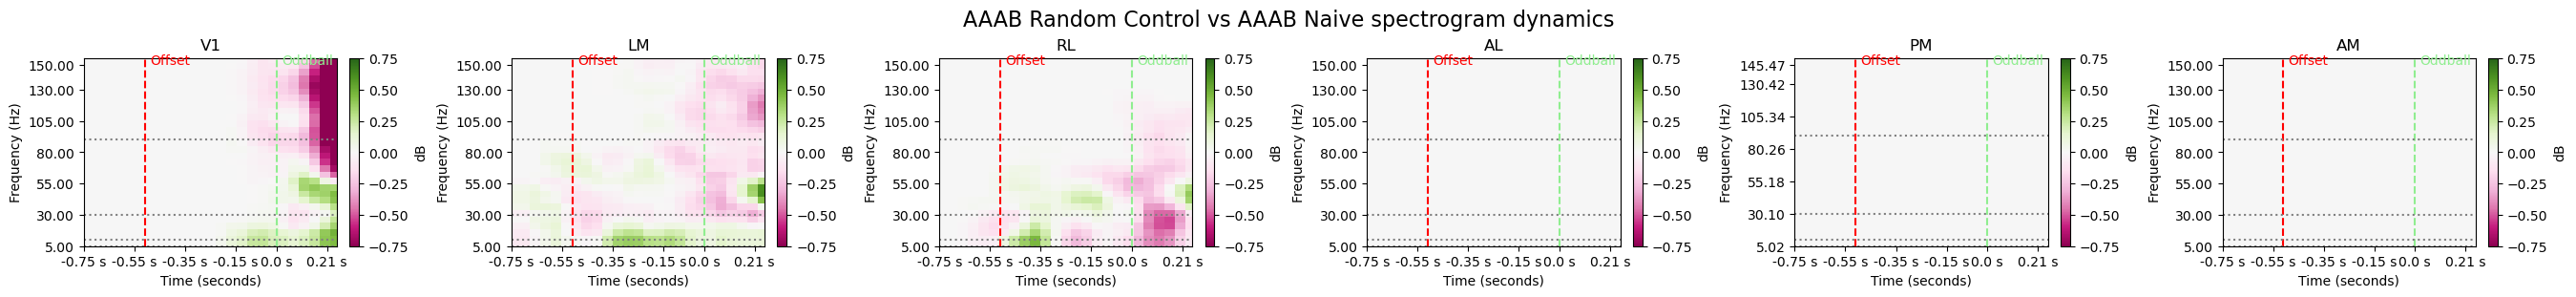

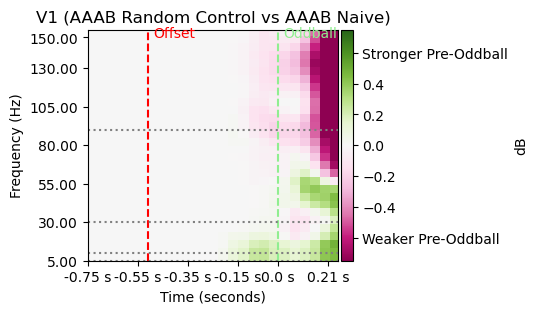

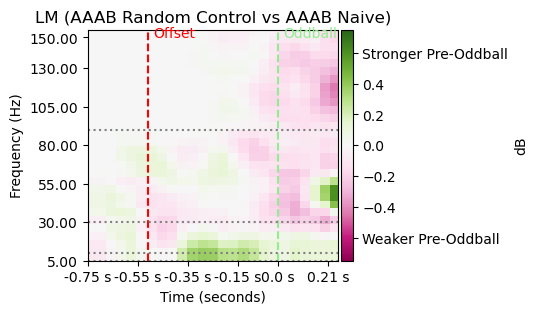

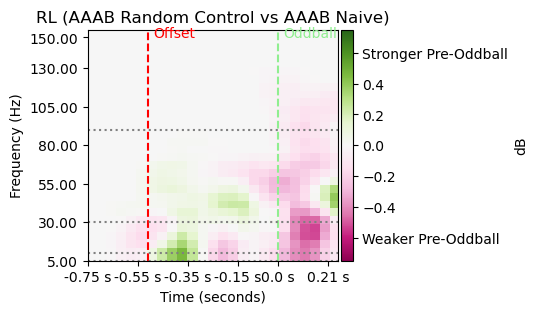

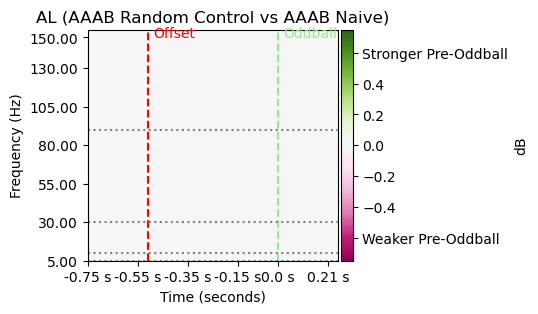

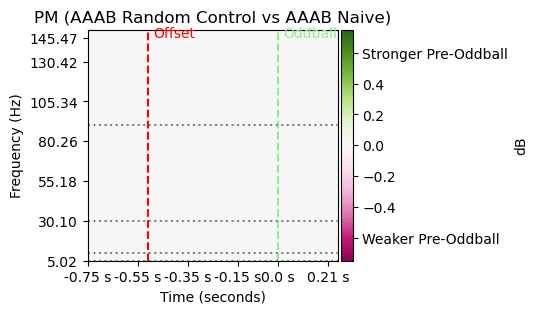

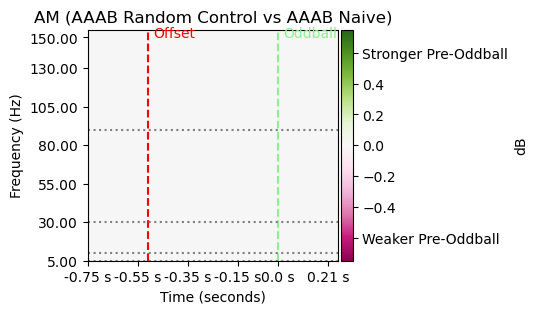

In [27]:
for (name, _, _) in CONTRASTS:
    contrast_title = functools.partial(contrast_stattitle, name)
    contrast_tfrs = contrasts[name]
    contrast_tfrs.plot(signals=anatomical_areas, sigtitle=stattitle, cmap='PiYG', vmax=CONTRAST_VMAXES[name], vmin=-CONTRAST_VMAXES[name], title=CONTRAST_TITLES[name] + " spectrogram dynamics",
                       figure="oscillatory_prestim_contrasts_4-3_%s_05.pdf" % name, **ADAPTED_EVENTS)
    for area in anatomical_areas:
        os.makedirs("oscillatory_prestim_contrasts_4-3_%s_05/" % name, exist_ok=True)
        contrast_tfrs.signals[area].plot(title=contrast_title(area, contrasts[name].signals[area]), cmap='PiYG', vmax=CONTRAST_VMAXES[name], vmin=-CONTRAST_VMAXES[name],
                                         filename="oscillatory_prestim_contrasts_4-3_%s_05/%s.pdf" % (name, area), cbar_ends=("Stronger Pre-Oddball", "Weaker Pre-Oddball"), **ADAPTED_EVENTS)